# Fairness auditing for subgroups using Fairness Aware Counterfactuals for Subgroups (FACTS).

[FACTS](https://arxiv.org/abs/2306.14978) is an efficient, model-agnostic, highly parameterizable, and explainable framework for evaluating subgroup fairness through counterfactual explanations.

In this notebook, we will see how to use this algorithm for discovering subgroups where the bias of a model (logistic regression for simplicity) between Males and Females is high. We will use the Adult dataset.

# Preliminaries

Dataset used: 
- `adult (Adult)` :<br>The UCI Adult dataset contains 14 features, which can be divided into two categories: demographic and income-related.<br> The demographic features include:

    age: continuous.<br>
    fnlwgt : continuous, represents final weight, which is the number of units in the target population that the responding unit represents.<br>
    workclass: categorical, with values 'Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay'.<br>
    education: categorical, with values '11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th', ..., '9th', 'Doctorate', '12th', '1st-4th', 'Preschool'.<br>
    education-num: continuous with values 1 to 16, one number assigned to each label of education feature.<br>
    marital-status: categorical, with values 'Never-married', 'Married-civ-spouse', 'Widowed', 'Separated', 'Divorced', 'Married-spouse-absent', 'Married-AF-spouse'.<br>
    occupation: categorical, with values such as 'Machine-op-inspct', 'Farming-fishing', 'Protective-serv'.<br>
    relationship: categorical, with values 'Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife', 'Other-relative'.<br>
    race: categorical, with values such as white, black, and Asian.<br>
    sex: categorical, with values male and female.<br>
    
    The income-related features include:<br>

    hours-per-week: continuous.<br>
    native-country: categorical, with values such as United-States, Mexico, and Germany.<br>
    capital-gain: continuous, represent the amount of money an individual has gained from the sale of investments such as stocks, bonds, or real estate.<br>
    capital-loss: continuous, represent the amount of money an individual has lost from the sale of investments such as stocks, bonds, or real estate..<br>
    The target feature is the income, which is binary:<br>
    income: categorical, with values less than or equal to 50K and greater than 50K.<br>

Reference Links: https://archive.ics.uci.edu/ml/datasets/adult

## Import libraries

We import the dependencies we will need. There is no need to fret over this part, continue below.

**Note**: you can safely ignore the warnings shown below.

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import aif360.algorithms.postprocessing.facts as facts
from aif360.algorithms.postprocessing.facts.clean import clean_dataset
from aif360.algorithms.postprocessing.facts.misc import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from aif360.algorithms.postprocessing.facts.models import customLogisticRegression
from aif360.algorithms.postprocessing.facts.parameters import ParameterProxy
from aif360.algorithms.postprocessing.facts.formatting import (
    recourse_report_reverse,
    print_recourse_report,
    print_recourse_report_cumulative,
    print_recourse_report_KStest_cumulative
)
from aif360.algorithms.postprocessing.facts.utils import load_rules_by_if, save_rules_by_if

from IPython.display import Markdown, display

C:\Users\dinos\anaconda3\envs\work\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
C:\Users\dinos\anaconda3\envs\work\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_mask

Below, you can change the `random_seed` variable to `None` if you would like for the pseudo-random parts to actually change between runs. We have set it to a value simply for reproducibility purposes.

Moreover, the two variables `precomputed_rules_file` and `precomputed_rules_with_cumulative_file` hold the filenames where some intermediate results of our algorithms can be stored (for more details, continue further). This is only for convenience, because these results take a relatively long time to compute (~30 minutes). *Note*: we have not provided pre-computed such files, so:
- you will need to run the whole notebook at least once.
- you can safely change the names of these two files to anything you like, they do not exist.

In [2]:
from pathlib import Path

random_seed = 131313 # for reproducibility

# names of files to be used as caches for the comparative subgroup counterfactuals. Replace with anything you like.
precomputed_rules_file = Path(".") / "rulesAdult_sex_atomic.data"
precomputed_rules_with_cumulative_file = Path(".") / "rulesAdult_sex_cumulative.data"

## Load Dataset

Currently, we load the adult dataset from the repository of the "FairTest" framework (found [here](https://github.com/columbia/fairtest)). There is no dependence of our work to FairTest, it is thus not necessary to know anything about it. It is planned to transition to using aif360's provided Adult dataset, but the migration has not yet finished.

In [3]:
urlfile= "https://raw.githubusercontent.com/columbia/fairtest/master/data/adult/adult.csv"

X = pd.read_csv(urlfile)
df = clean_dataset(X, "adult")

df.head()

,age,Workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,"(34.0, 41.0]",State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,FullTime,United-States,0
1,"(41.0, 50.0]",Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Married,White,Male,0,0,PartTime,United-States,0
2,"(34.0, 41.0]",Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,FullTime,United-States,0
3,"(50.0, 90.0]",Private,7,Married-civ-spouse,Handlers-cleaners,Married,Black,Male,0,0,FullTime,United-States,0
4,"(26.0, 34.0]",Private,13,Married-civ-spouse,Prof-specialty,Married,Black,Female,0,0,FullTime,Cuba,0


## Model training and test

We divide our data into train and test sets, and then use the train set to train a simple logistic regression model. This will serve as the demonstrative model, which we will then treat as a black box and apply our algorithm.

Of course, any model can be used in its place. Our purpose here is not to produce a very good model, but to audit the fairness of an arbitrarily chosen one.

In [8]:
y = df['income']
X = df.drop('income', axis=1)

num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=random_seed, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [5]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='income')
model.predict(X_test.iloc[:100, :])

CPU times: total: 3.53 s
Wall time: 2.32 s


array([0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0.])

In [6]:
positive_label = 1
negative_label = 0
preds_Xtest = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds_Xtest))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     10205
           1       0.73      0.61      0.67      3362

    accuracy                           0.85     13567
   macro avg       0.80      0.77      0.78     13567
weighted avg       0.84      0.85      0.84     13567



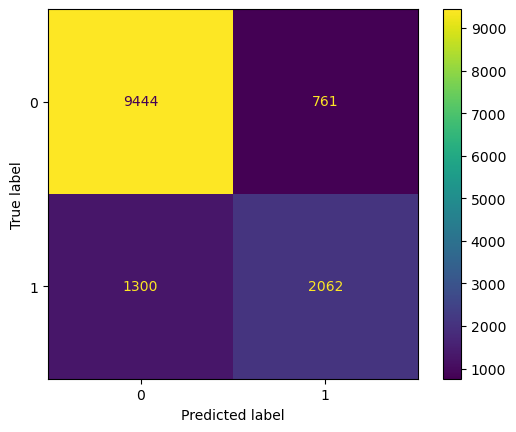

In [7]:
conf_matrix = confusion_matrix(y_test, preds_Xtest)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

# Main Contribution

Here begins the implementation of the actual contribution of our work. Specifically, we demonstrate the generation of candidate subgroup counterfactuals and, as the next phase, the choice of those subgroup counterfactuals that showcase the highest unfairness, according to several metrics.

## Find all valid if-thens with all respective coverages and atomic correctness, for all subgroups.

The first step is to generate as many as possible (and tractable) candidate counterfactuals, in the form of if-then clauses (e.g. if your education is "High School", make it "College"). At the same time, we compute the *effectiveness* for each such if-then clause, which is defined as the percentage of the subgroup which the suggestion actually manages to flip to the positive class (in the previous example, from those people who have "High School" and receive 0 from the model, what percentage receives 1 if we were to change their education to "College").

For more details on these concepts and more rigorous definitions, see our paper.

*Note*: our framework provides somewhat extensive parameterization. Descriptions of all choices are provided in the documentation. In this demo, we have tried to keep only some basic defaults for easier understanding. For some cases, this was a little difficult, so we have provided appropriate comments in the following code in order to inform the reader of those parts of the code that should be ignored, at least at first glance.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [13]:
#Uncomment if you want to find new rules with different parameters

ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
    X=X_test,
    model=model,
    sensitive_attribute='sex',
    freqitem_minsupp = 0.01,
    # the following two options apply specifically for the adult dataset used here and are used to prune some obviously nonsensical suggestions
    # they should be set to False for any user-provided dataset
    drop_infeasible = True,
    drop_above = True
)

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Computing frequent itemsets for each subgroup of the affected instances.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.20s/it]

Computing the intersection between the frequent itemsets of each subgroup of the affected instances.



100%|████████████████████████████████████████████████████████████████████████| 27769/27769 [00:00<00:00, 481299.65it/s]


Computing all valid if-then pairs between the common frequent itemsets of each subgroup of the affected instances and the frequent itemsets of the unaffacted instances.


100%|██████████████████████████████████████████████████████████████████████████| 13347/13347 [00:03<00:00, 4264.32it/s]


Computing correctenesses for all valid if-thens.


100%|██████████████████████████████████████████████████████████████████████████| 104618/104618 [25:25<00:00, 68.60it/s]


Number of if-thens: 104618


In the last step of the previous cell, we grouped all counterfactuals by their "if" clause. Thus, the variable `rules_by_if` now contains the main representation used by our framework, called *Comparative Subgroup Counterfactuals*.

Since the computation above is somewhat expensive, we provide, in the following cell, a way to save and load the `rules_by_if` variable from disk.

In [10]:
## Use this for loading rules from disk
# rules_by_if = load_rules_by_if(precomputed_rules_file)

## Use this for saving rules on disk
# save_rules_by_if(precomputed_rules_file, rules_by_if)

## Definition of feature-level parameterization

From this point onwards, our framework needs to have a way to quantify the *cost* of a change / counterfactual. If we tell a group to change from "High School" to "College", how costly should this change be?

Here, the user can provide custom cost functions for each feature, which are then added for the total cost. However, we also provide a default implementation, which is the following:
- for numeric features, the absolute difference between initial and changed value.
- for categorical features, 1 if their value changes and 0 if it does not.
- for ordinal features, the number of steps the two values are apart.

Finally, for all 3 cases, the cost is multiplied by a user-chosen feature weight.

In the simplest case, you can play with these weights if you want. Below, we have chosen some, in our opinion, sensible values.

*Note*: in contrast to other methods, our framework is somewhat robust to the costs, in the sense that it does not matter very much if the costs are chosen "correctly" for our algorithm to successfully audit fairness. More details on this are discussed in our paper.

In [11]:
num_features = ['education-num', 'capital-gain', 'capital-loss']
cate_features = ['age', 'Workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
ord_features = ['hours-per-week']

feature_weights = {"race" : 100 , "sex": 100, "marital-status": 5, "relationship":5, "age": 10, "occupation": 4, "Workclass": 2, "native-country": 4,
                    "hours-per-week":2, "capital-gain": 1, "capital-loss":1, "education-num": 3}

## the following is basically boilerplate. You can safely ignore it, at least at first glance. Seek further information in the documentation.
features_with_binary_cost = cate_features
features_with_proportional_cost = num_features
comparators = facts.feature_change_builder(
    X_test,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    ord_cols=ord_features,
    feature_weights=feature_weights,
    num_normalization=True,
    feats_to_normalize = ["capital-gain", "capital-loss"]
)
params = ParameterProxy(featureChanges=comparators)

We continue with the rankings and selection of rules according to each of the proposed metrics of our paper.

*Note*: From here on, if too intimidating, you can use the code as-is, as we have provided some, in our opinion, reasonable defaults. At first glance, we believe one should concentrate on the output of our algorithm.

## Macro Viewpoint

### Equal Cost of Effectiveness (Macro)

For each set of rules with the safe "if", we compare the minimum cost counterfactual that achieves a specified effectiveness threshold for Males and Females.

In [16]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",
        "remove-fair-rules",
        "keep-only-min-change"
    ],
    cor_threshold=0.5,
    secondary_sorting_objectives=[
        # "min-group-cost",
        "max-group-corr"
    ],
    params=params
)

# cum_cors = facts.cum_corr_costs_all_minimal(top_rules, X_test, model, sensitive_attribute="sex", params=params)
cum_cors = dict()

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

If Workclass =  Private, age = (34.0, 41.0], hours-per-week = FullTime, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.16% covered out of 6566
		Make Workclass =  Self-emp-inc, age = (41.0, 50.0], hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 53.95%.
		Aggregate cost of the above recourses = 24.00
	Protected Subgroup ' Female', 1.05% covered out of 4178
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 54.55%.
		Aggregate cost of the above recourses = 10.00
	Bias against  Male due to Equal Effectiveness. Unfairness score = 14.
If Workclass =  Private, age = (34.0, 41.0], marital-status =  Never-married, race =  White, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.89% covered out of 6566
		Make Workclass =  Federal-gov, age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 56.45%

### Equal Choice for Recourse

For each set of rules with the safe "if", we compare the number of counterfactuals ("then" clauses) that achieve a specified effectiveness threshold for Males and Females.

In [17]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",
        # "remove-fair-rules"
    ],
    cor_threshold=0.2,
    secondary_sorting_objectives=[
        # "min-group-cost",
        # "max-group-corr"
    ],
    params=params
)

# cum_cors = facts.cum_corr_costs_all_minimal(top_rules, X_test, model, sensitive_attribute="sex", params=params)
cum_cors = dict()

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors,
    show_subgroup_costs=True
)

If age = (26.0, 34.0], hours-per-week = FullTime, occupation =  Sales:
	Protected Subgroup ' Male', 1.10% covered out of 6566
		Make age = (41.0, 50.0], hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 51.39%.
		Make age = (41.0, 50.0], hours-per-week = OverTime, occupation =  Prof-specialty with effectiveness 50.00%.
		Make age = (34.0, 41.0], hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 50.00%.
		Make age = (41.0, 50.0], occupation =  Exec-managerial with effectiveness 50.00%.
		Make age = (41.0, 50.0], occupation =  Prof-specialty with effectiveness 36.11%.
		Make age = (34.0, 41.0], hours-per-week = OverTime, occupation =  Prof-specialty with effectiveness 50.00%.
		Make age = (34.0, 41.0], occupation =  Prof-specialty with effectiveness 25.00%.
		Make age = (34.0, 41.0], occupation =  Exec-managerial with effectiveness 36.11%.
		Make age = (41.0, 50.0], hours-per-week = OverTime with effectiveness 50.00%.
		Make hours-per-w

## Micro viewpoint

Fairness definitions based on cumulative distribution of cost - correctness.

Briefly, this means that we now consider many "thens" at once, and we calculate their effectiveness as the percentage of individuals that are corrected by at least one "then" clause. With this new concept, we sort the "then" clauses of each "if" in increasing order of cost, and calculate the "running" effectiveness. This could be seen as an answer to the question: given any cost "budget", what is the maximum effectiveness we can achieve? (as a matter of fact, this is also one of the metrics we will use)

For further explanation of these concepts, see our paper.

We start by computing the cumulative effectiveness of the actions for each subgroup and each value of the protected attribute.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [18]:
rules_with_cumulative = facts.cum_corr_costs_all(rules_by_if, X_test, model, sensitive_attribute="sex", params=params)

100%|████████████████████████████████████████████████████████████████████████████| 13118/13118 [11:00<00:00, 19.85it/s]


In [27]:
## Use this for loading rules from disk
# rules_with_cumulative = load_rules_by_if(precomputed_rules_with_cumulative_file)

## Use this for saving rules on disk
# save_rules_by_if(precomputed_rules_with_cumulative_file, rules_with_cumulative)

### Equal (Conditional) Mean Recourse

Here, for each subgroup ("if" clause), we compute the arithmetic mean of the cost needed to flip the subgroup's individuals. The "conditional" part refers to the fact that we divide with the total effectiveness achieved, since it is not guaranteed to be 100%.

If hours-per-week = FullTime, marital-status =  Never-married, native-country =  United-States, race =  Black:
	Protected Subgroup ' Male', 2.19% covered out of 6566
		Make marital-status =  Married-civ-spouse with effectiveness 0.69% and counterfactual cost = 5.0.
		Make hours-per-week = OverTime, marital-status =  Married-civ-spouse with effectiveness 1.39% and counterfactual cost = 7.0.
		Make hours-per-week = OverTime, race =  White with effectiveness 1.39% and counterfactual cost = 102.0.
		Make marital-status =  Married-civ-spouse, race =  White with effectiveness 1.39% and counterfactual cost = 105.0.
		Make hours-per-week = MidTime, marital-status =  Married-civ-spouse, race =  White with effectiveness 1.39% and counterfactual cost = 107.0.
		Make hours-per-week = OverTime, marital-status =  Married-civ-spouse, race =  White with effectiveness 1.39% and counterfactual cost = 107.0.
		Make hours-per-week = PartTime, marital-status =  Married-civ-spouse, race =  White with effect

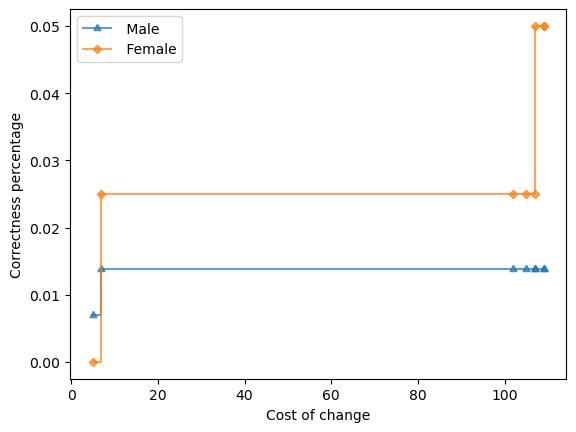

If capital-loss = 0, occupation =  Other-service, race =  Black:
	Protected Subgroup ' Male', 1.40% covered out of 6566
		Make occupation =  Exec-managerial with effectiveness 1.09% and counterfactual cost = 4.0.
		Make occupation =  Craft-repair, race =  White with effectiveness 1.09% and counterfactual cost = 104.0.
		Make occupation =  Transport-moving, race =  White with effectiveness 1.09% and counterfactual cost = 104.0.
		Make occupation =  Prof-specialty, race =  White with effectiveness 1.09% and counterfactual cost = 104.0.
		Make occupation =  Sales, race =  White with effectiveness 1.09% and counterfactual cost = 104.0.
		Make occupation =  Adm-clerical, race =  White with effectiveness 1.09% and counterfactual cost = 104.0.
		Make occupation =  Tech-support, race =  White with effectiveness 1.09% and counterfactual cost = 104.0.
		Make occupation =  Protective-serv, race =  White with effectiveness 1.09% and counterfactual cost = 104.0.
		Make occupation =  Prof-specialty,

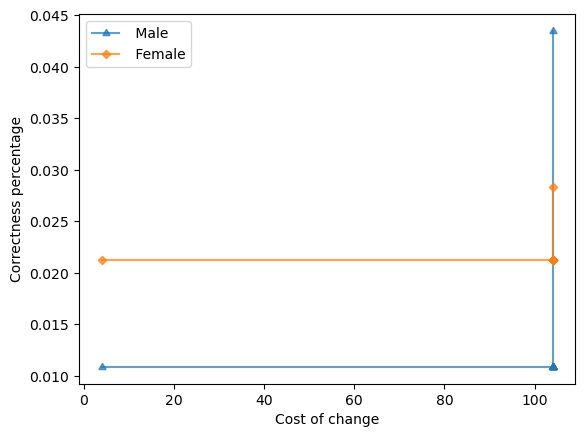

If Workclass =  Private, native-country =  United-States, race =  Black, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.87% covered out of 6566
		Make relationship =  Married with effectiveness 0.81% and counterfactual cost = 5.0.
		Make race =  White with effectiveness 0.81% and counterfactual cost = 100.0.
		Make race =  White, relationship =  Married with effectiveness 1.63% and counterfactual cost = 105.0.
		Make Workclass =  Self-emp-not-inc, race =  White, relationship =  Married with effectiveness 1.63% and counterfactual cost = 107.0.
		Make Workclass =  Local-gov, race =  White, relationship =  Married with effectiveness 1.63% and counterfactual cost = 107.0.
		Make Workclass =  State-gov, race =  White, relationship =  Married with effectiveness 1.63% and counterfactual cost = 107.0.
		Make Workclass =  Self-emp-inc, race =  White, relationship =  Married with effectiveness 2.44% and counterfactual cost = 107.0.
		Make Workclass =  Federal-gov, race =  White, r

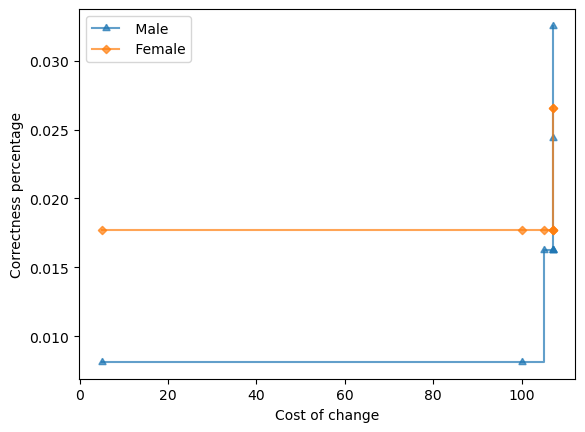

If race =  Black, relationship =  Not-in-family:
	Protected Subgroup ' Male', 2.73% covered out of 6566
		Make relationship =  Married with effectiveness 1.68% and counterfactual cost = 5.0.
		Make race =  White with effectiveness 1.68% and counterfactual cost = 100.0.
		Make race =  Asian-Pac-Islander, relationship =  Married with effectiveness 1.68% and counterfactual cost = 105.0.
		Make race =  White, relationship =  Married with effectiveness 2.79% and counterfactual cost = 105.0.
		Aggregate cost of the above recourses = 45.00
	Protected Subgroup ' Female', 3.88% covered out of 4178
		Make relationship =  Married with effectiveness 2.47% and counterfactual cost = 5.0.
		Make race =  White with effectiveness 2.47% and counterfactual cost = 100.0.
		Make race =  White, relationship =  Married with effectiveness 2.47% and counterfactual cost = 105.0.
		Make race =  Asian-Pac-Islander, relationship =  Married with effectiveness 2.47% and counterfactual cost = 105.0.
		Aggregate cost 

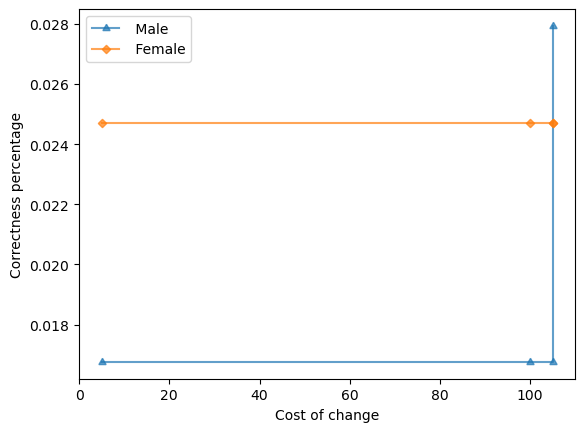

If Workclass =  Private, marital-status =  Never-married, native-country =  United-States, race =  Black:
	Protected Subgroup ' Male', 2.95% covered out of 6566
		Make marital-status =  Married-civ-spouse with effectiveness 1.03% and counterfactual cost = 5.0.
		Make race =  White with effectiveness 1.03% and counterfactual cost = 100.0.
		Make marital-status =  Divorced, race =  White with effectiveness 1.03% and counterfactual cost = 105.0.
		Make marital-status =  Married-civ-spouse, race =  White with effectiveness 1.03% and counterfactual cost = 105.0.
		Make Workclass =  Self-emp-not-inc, marital-status =  Married-civ-spouse, race =  White with effectiveness 1.03% and counterfactual cost = 107.0.
		Make Workclass =  State-gov, marital-status =  Married-civ-spouse, race =  White with effectiveness 1.03% and counterfactual cost = 107.0.
		Make Workclass =  Local-gov, marital-status =  Married-civ-spouse, race =  White with effectiveness 1.03% and counterfactual cost = 107.0.
		Make

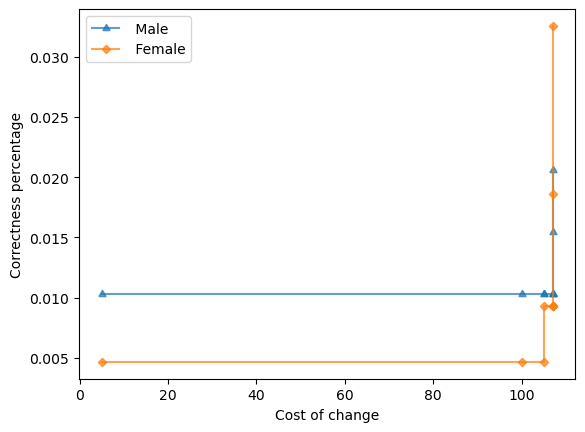

If hours-per-week = FullTime, race =  Black, relationship =  Not-in-family:
	Protected Subgroup ' Male', 1.84% covered out of 6566
		Make relationship =  Married with effectiveness 1.65% and counterfactual cost = 5.0.
		Make hours-per-week = OverTime, relationship =  Married with effectiveness 4.13% and counterfactual cost = 7.0.
		Make race =  White with effectiveness 4.13% and counterfactual cost = 100.0.
		Make hours-per-week = OverTime, race =  White with effectiveness 4.13% and counterfactual cost = 102.0.
		Make race =  Asian-Pac-Islander, relationship =  Married with effectiveness 4.13% and counterfactual cost = 105.0.
		Make race =  White, relationship =  Married with effectiveness 4.13% and counterfactual cost = 105.0.
		Make hours-per-week = MidTime, race =  White, relationship =  Married with effectiveness 4.13% and counterfactual cost = 107.0.
		Make hours-per-week = OverTime, race =  White, relationship =  Married with effectiveness 4.13% and counterfactual cost = 107.0.
	

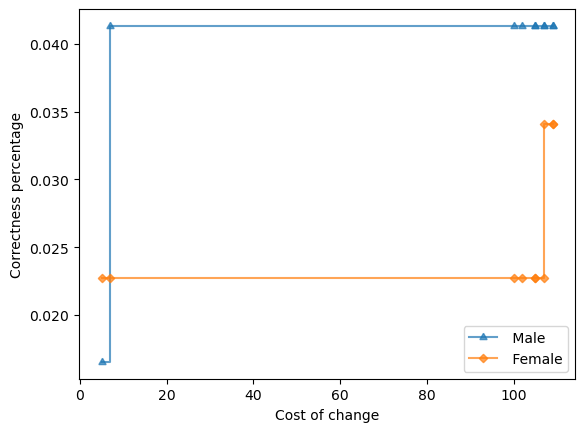

In [20]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="fairness-of-mean-recourse-conditional",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=10,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

### Equal Effectiveness

Here, we simply compare, for each subgroup, the total effectiveness achieved for Males and Females (i.e. using all "then" clauses).

If capital-gain = 0, education-num = 9, hours-per-week = FullTime, native-country =  United-States, occupation =  Exec-managerial:
	Protected Subgroup ' Male', 1.02% covered out of 6566
		Make hours-per-week = OverTime with effectiveness 43.28% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 43.28% and counterfactual cost = 3.0.
		Make education-num = 10, hours-per-week = OverTime with effectiveness 65.67% and counterfactual cost = 5.0.
		Make education-num = 10, hours-per-week = OverTime, occupation =  Sales with effectiveness 65.67% and counterfactual cost = 9.0.
		Aggregate cost of the above recourses = 0.66
	Protected Subgroup ' Female', 1.53% covered out of 4178
		Make hours-per-week = OverTime with effectiveness 7.81% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 7.81% and counterfactual cost = 3.0.
		Make education-num = 10, hours-per-week = OverTime with effectiveness 7.81% and counterfactual cost = 5.0.
		Make education

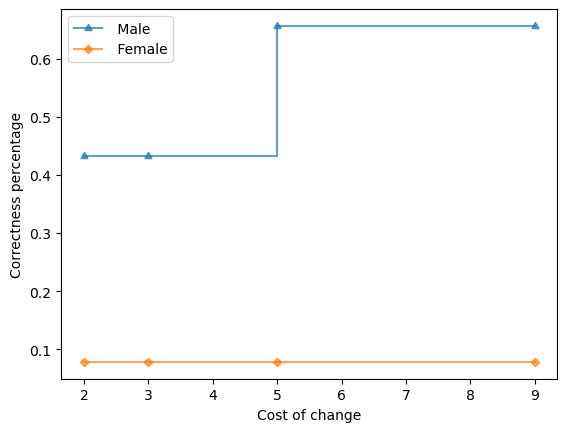

If capital-loss = 0, education-num = 10, hours-per-week = FullTime, native-country =  United-States, occupation =  Sales:
	Protected Subgroup ' Male', 1.04% covered out of 6566
		Make hours-per-week = OverTime with effectiveness 33.82% and counterfactual cost = 2.0.
		Make occupation =  Exec-managerial with effectiveness 33.82% and counterfactual cost = 4.0.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 54.41% and counterfactual cost = 6.0.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with effectiveness 54.41% and counterfactual cost = 8.0.
		Aggregate cost of the above recourses = 0.54
	Protected Subgroup ' Female', 1.05% covered out of 4178
		Make hours-per-week = OverTime with effectiveness 4.55% and counterfactual cost = 2.0.
		Make occupation =  Exec-managerial with effectiveness 4.55% and counterfactual cost = 4.0.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 4.55% and counterfactual c

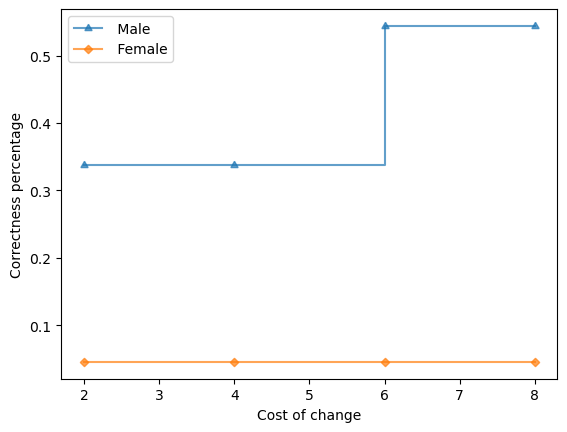

If Workclass =  Private, age = (41.0, 50.0], occupation =  Machine-op-inspct:
	Protected Subgroup ' Male', 1.45% covered out of 6566
		Make occupation =  Craft-repair with effectiveness 9.47% and counterfactual cost = 4.0.
		Make occupation =  Adm-clerical with effectiveness 11.58% and counterfactual cost = 4.0.
		Make occupation =  Sales with effectiveness 23.16% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 29.47% and counterfactual cost = 4.0.
		Make occupation =  Tech-support with effectiveness 29.47% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 46.32% and counterfactual cost = 4.0.
		Make Workclass =  Self-emp-not-inc, occupation =  Prof-specialty with effectiveness 46.32% and counterfactual cost = 6.0.
		Make Workclass =  State-gov, occupation =  Prof-specialty with effectiveness 46.32% and counterfactual cost = 6.0.
		Make Workclass =  Local-gov, occupation =  Prof-specialty with effectiveness 46.3

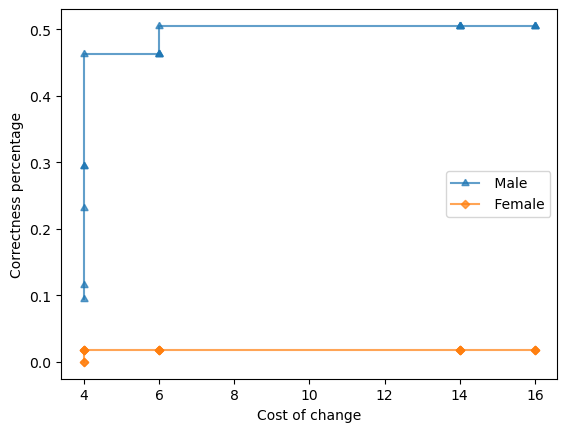

If age = (41.0, 50.0], native-country =  United-States, occupation =  Machine-op-inspct:
	Protected Subgroup ' Male', 1.29% covered out of 6566
		Make occupation =  Craft-repair with effectiveness 7.06% and counterfactual cost = 4.0.
		Make occupation =  Adm-clerical with effectiveness 10.59% and counterfactual cost = 4.0.
		Make occupation =  Sales with effectiveness 22.35% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 29.41% and counterfactual cost = 4.0.
		Make occupation =  Tech-support with effectiveness 29.41% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 48.24% and counterfactual cost = 4.0.
		Make age = (50.0, 90.0], occupation =  Craft-repair with effectiveness 48.24% and counterfactual cost = 14.0.
		Make age = (50.0, 90.0], occupation =  Adm-clerical with effectiveness 48.24% and counterfactual cost = 14.0.
		Make age = (50.0, 90.0], occupation =  Sales with effectiveness 48.24% and counterfactu

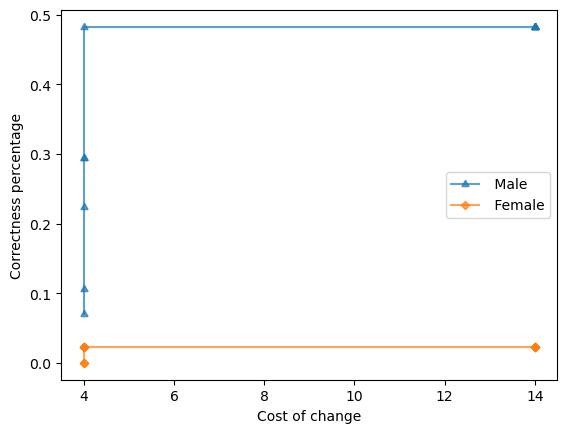

If capital-gain = 0, capital-loss = 0, education-num = 9, hours-per-week = FullTime, native-country =  United-States, occupation =  Sales:
	Protected Subgroup ' Male', 1.25% covered out of 6566
		Make education-num = 10, hours-per-week = OverTime with effectiveness 35.37% and counterfactual cost = 5.0.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 36.59% and counterfactual cost = 6.0.
		Make education-num = 10, occupation =  Exec-managerial with effectiveness 36.59% and counterfactual cost = 7.0.
		Make education-num = 10, hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 52.44% and counterfactual cost = 9.0.
		Aggregate cost of the above recourses = 0.52
	Protected Subgroup ' Female', 1.10% covered out of 4178
		Make education-num = 10, hours-per-week = OverTime with effectiveness 6.52% and counterfactual cost = 5.0.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 6.52% and counterfactual

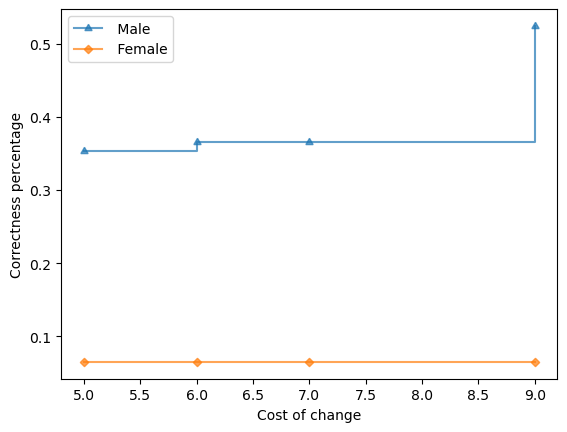

If Workclass =  Private, capital-gain = 0, education-num = 9, hours-per-week = FullTime, native-country =  United-States, occupation =  Machine-op-inspct, race =  White:
	Protected Subgroup ' Male', 2.28% covered out of 6566
		Make hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 40.00% and counterfactual cost = 6.0.
		Make education-num = 10, hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 54.00% and counterfactual cost = 9.0.
		Aggregate cost of the above recourses = 0.54
	Protected Subgroup ' Female', 1.17% covered out of 4178
		Make hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 8.16% and counterfactual cost = 6.0.
		Make education-num = 10, hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 8.16% and counterfactual cost = 9.0.
		Aggregate cost of the above recourses = 0.08
	Bias against  Female due to Equal Effectiveness. Unfairness score = 0.458.
	Cumulative effectiveness 

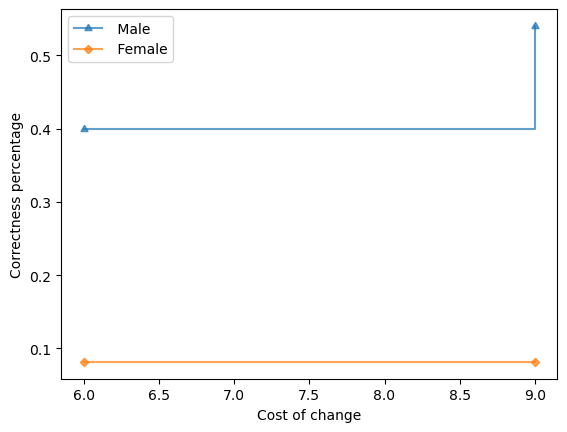

If Workclass =  Private, age = (26.0, 34.0], capital-gain = 0, capital-loss = 0, native-country =  United-States, occupation =  Sales, race =  White:
	Protected Subgroup ' Male', 1.90% covered out of 6566
		Make occupation =  Prof-specialty with effectiveness 13.60% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 25.60% and counterfactual cost = 4.0.
		Make age = (34.0, 41.0] with effectiveness 25.60% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 35.20% and counterfactual cost = 10.0.
		Make age = (34.0, 41.0], occupation =  Prof-specialty with effectiveness 36.80% and counterfactual cost = 14.0.
		Make age = (34.0, 41.0], occupation =  Exec-managerial with effectiveness 41.60% and counterfactual cost = 14.0.
		Make age = (41.0, 50.0], occupation =  Prof-specialty with effectiveness 41.60% and counterfactual cost = 14.0.
		Make age = (41.0, 50.0], occupation =  Exec-managerial with effectiveness 49.60% and counterfac

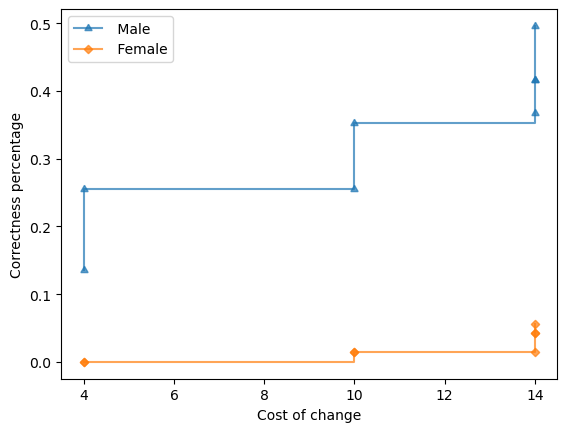

In [21]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="total-correctness",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules",
        # "keep-only-min-change"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric= True
)

### Equal Cost of Effectiveness (micro)

Here, similarly to the respective macro metric, we calculate the minimum cost budget needed to achieve a specified effectiveness threshold, and we consider a subgroup to exhibit bias if this is very different for Males and Females.

If age = (26.0, 34.0], marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Male', 5.85% covered out of 6566
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 28.12% and counterfactual cost = 10.0.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 41.67% and counterfactual cost = 20.0.
		Aggregate cost of the above recourses = 20.00
	Protected Subgroup ' Female', 6.01% covered out of 4178
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 35.46% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Bias against  Male due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above recourses:


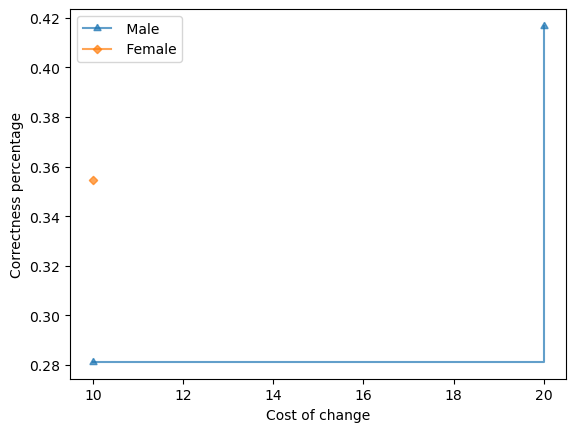

If age = (26.0, 34.0], capital-loss = 0, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Male', 5.68% covered out of 6566
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 26.54% and counterfactual cost = 10.0.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 40.21% and counterfactual cost = 20.0.
		Aggregate cost of the above recourses = 20.00
	Protected Subgroup ' Female', 5.74% covered out of 4178
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 32.92% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Bias against  Male due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above recourses:


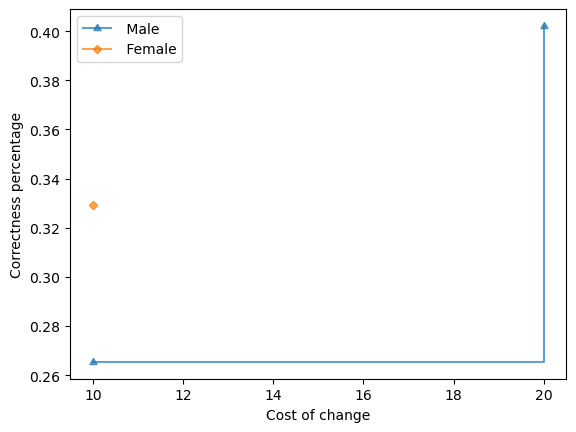

If age = (26.0, 34.0], capital-gain = 0, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Male', 5.67% covered out of 6566
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 27.42% and counterfactual cost = 10.0.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 41.40% and counterfactual cost = 20.0.
		Aggregate cost of the above recourses = 20.00
	Protected Subgroup ' Female', 5.70% covered out of 4178
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 34.87% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Bias against  Male due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above recourses:


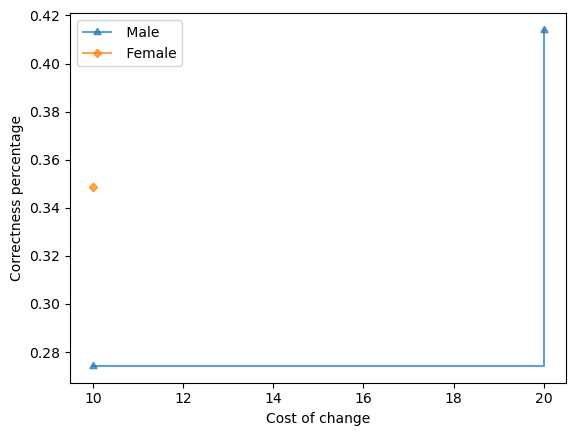

If age = (26.0, 34.0], capital-gain = 0, capital-loss = 0, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Male', 5.50% covered out of 6566
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 25.76% and counterfactual cost = 10.0.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 39.89% and counterfactual cost = 20.0.
		Aggregate cost of the above recourses = 20.00
	Protected Subgroup ' Female', 5.43% covered out of 4178
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 32.16% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Bias against  Male due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above recourses:


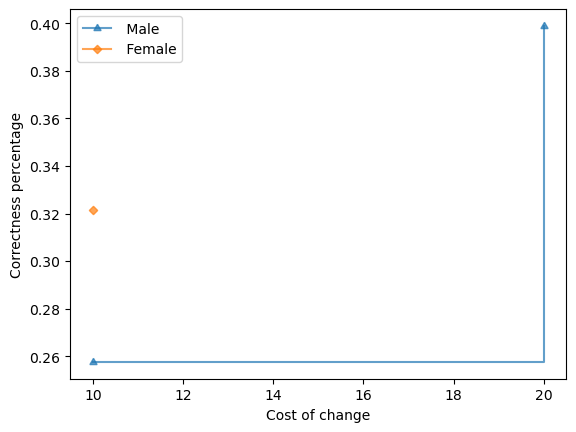

If age = (26.0, 34.0], capital-gain = 0, marital-status =  Never-married, race =  White, relationship =  Not-in-family:
	Protected Subgroup ' Male', 4.72% covered out of 6566
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 29.68% and counterfactual cost = 10.0.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 43.87% and counterfactual cost = 20.0.
		Aggregate cost of the above recourses = 20.00
	Protected Subgroup ' Female', 4.74% covered out of 4178
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 36.36% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Bias against  Male due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above recourses:


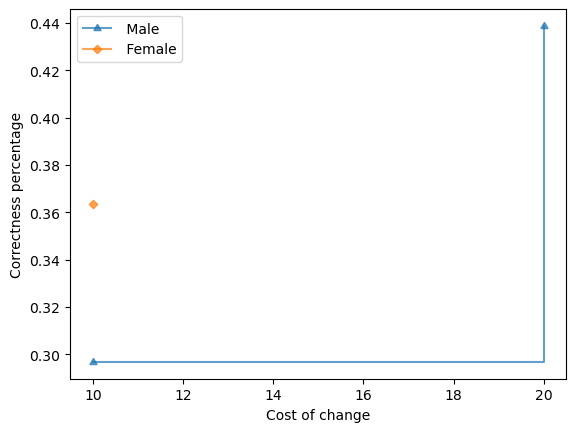

If age = (26.0, 34.0], capital-loss = 0, marital-status =  Never-married, race =  White, relationship =  Not-in-family:
	Protected Subgroup ' Male', 4.71% covered out of 6566
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 28.80% and counterfactual cost = 10.0.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 42.72% and counterfactual cost = 20.0.
		Aggregate cost of the above recourses = 20.00
	Protected Subgroup ' Female', 4.79% covered out of 4178
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 34.00% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Bias against  Male due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above recourses:


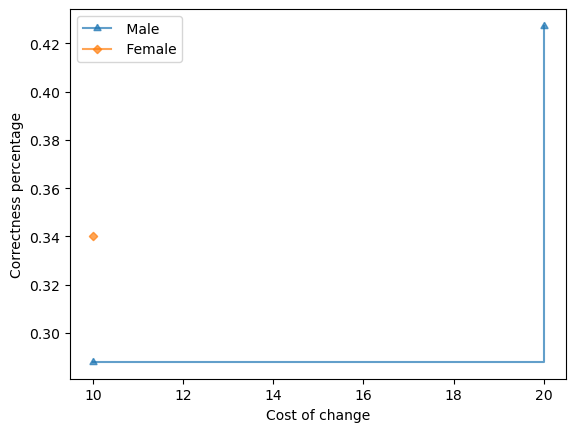

If Workclass =  Private, age = (26.0, 34.0], marital-status =  Never-married, native-country =  United-States, relationship =  Not-in-family:
	Protected Subgroup ' Male', 4.01% covered out of 6566
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 27.38% and counterfactual cost = 10.0.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 40.30% and counterfactual cost = 20.0.
		Aggregate cost of the above recourses = 20.00
	Protected Subgroup ' Female', 4.24% covered out of 4178
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 31.07% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Bias against  Male due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above recourses:


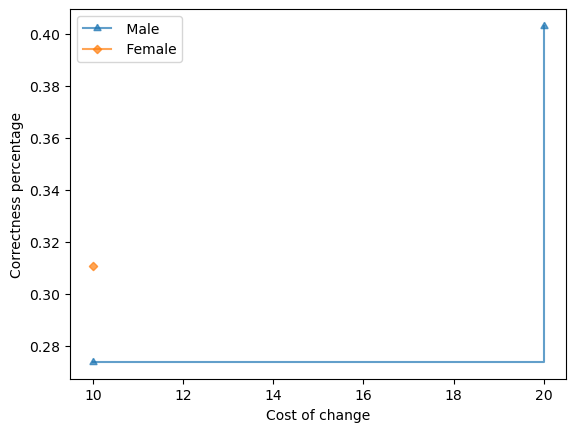

If Workclass =  Private, age = (26.0, 34.0], capital-gain = 0, marital-status =  Never-married, native-country =  United-States, relationship =  Not-in-family:
	Protected Subgroup ' Male', 3.85% covered out of 6566
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 26.09% and counterfactual cost = 10.0.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 39.53% and counterfactual cost = 20.0.
		Aggregate cost of the above recourses = 20.00
	Protected Subgroup ' Female', 3.97% covered out of 4178
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 30.12% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Bias against  Male due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above recourses:


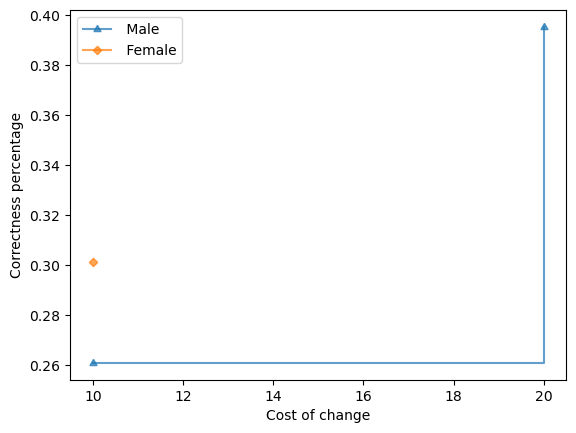

If Workclass =  Private, age = (26.0, 34.0], marital-status =  Never-married, race =  White, relationship =  Not-in-family:
	Protected Subgroup ' Male', 3.81% covered out of 6566
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 28.00% and counterfactual cost = 10.0.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 42.00% and counterfactual cost = 20.0.
		Aggregate cost of the above recourses = 20.00
	Protected Subgroup ' Female', 4.04% covered out of 4178
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 30.77% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Bias against  Male due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above recourses:


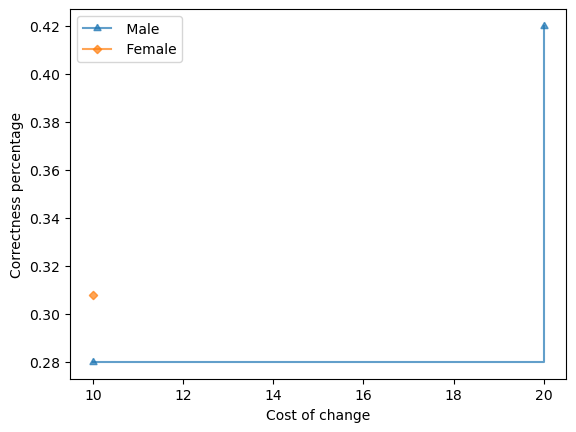

If age = (26.0, 34.0], hours-per-week = FullTime, marital-status =  Never-married, relationship =  Own-child:
	Protected Subgroup ' Male', 1.69% covered out of 6566
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 9.01% and counterfactual cost = 10.0.
		Make hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 18.02% and counterfactual cost = 12.0.
		Make hours-per-week = BrainDrain, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 18.02% and counterfactual cost = 14.0.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 19.82% and counterfactual cost = 20.0.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 26.13% and counterfactual cost = 20.0.
		Make age = (34.0, 41.0], hours-per-week = MidTime, marital-status =  Married-civ-spouse, relationship =

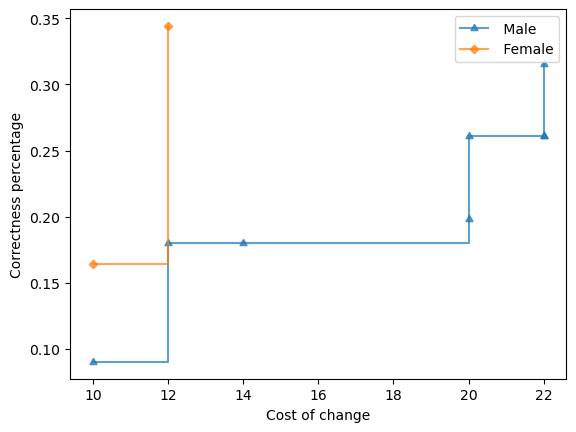

If age = (26.0, 34.0], capital-gain = 0, hours-per-week = FullTime, marital-status =  Never-married, relationship =  Own-child:
	Protected Subgroup ' Male', 1.61% covered out of 6566
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 8.49% and counterfactual cost = 10.0.
		Make hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 16.98% and counterfactual cost = 12.0.
		Make hours-per-week = BrainDrain, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 16.98% and counterfactual cost = 14.0.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 17.92% and counterfactual cost = 20.0.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 23.58% and counterfactual cost = 20.0.
		Make age = (41.0, 50.0], hours-per-week = MidTime, marital-status =  Married-civ-spou

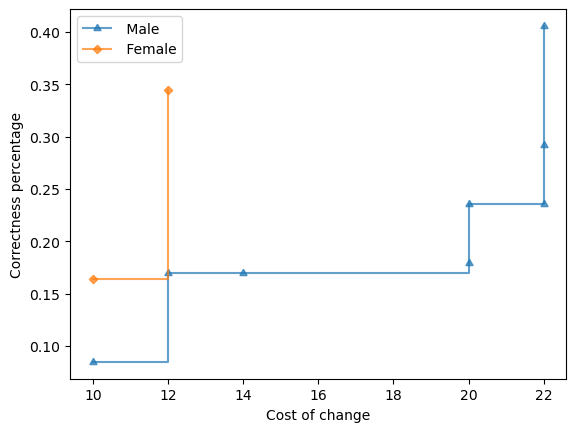

If Workclass =  Private, age = (26.0, 34.0], hours-per-week = FullTime, marital-status =  Never-married, relationship =  Own-child:
	Protected Subgroup ' Male', 1.49% covered out of 6566
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 9.18% and counterfactual cost = 10.0.
		Make hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 19.39% and counterfactual cost = 12.0.
		Make hours-per-week = BrainDrain, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 19.39% and counterfactual cost = 14.0.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 19.39% and counterfactual cost = 20.0.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 26.53% and counterfactual cost = 20.0.
		Make Workclass =  Local-gov, age = (41.0, 50.0], marital-status =  Married-civ-sp

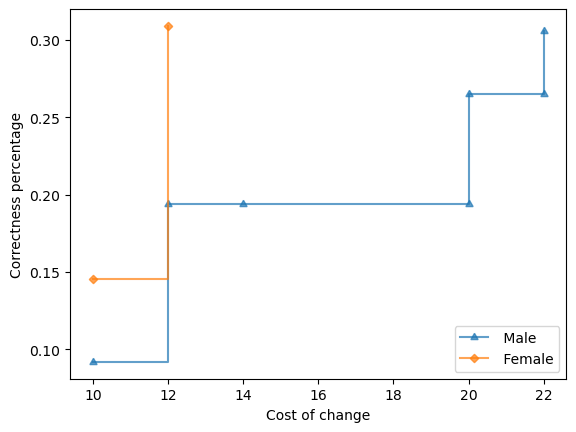

If age = (26.0, 34.0], capital-loss = 0, hours-per-week = FullTime, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Male', 2.67% covered out of 6566
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 19.43% and counterfactual cost = 10.0.
		Make hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 29.71% and counterfactual cost = 12.0.
		Make hours-per-week = BrainDrain, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 29.71% and counterfactual cost = 14.0.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 31.43% and counterfactual cost = 20.0.
		Aggregate cost of the above recourses = 20.00
	Protected Subgroup ' Female', 3.23% covered out of 4178
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 26.67% and counterfactual cost = 10.

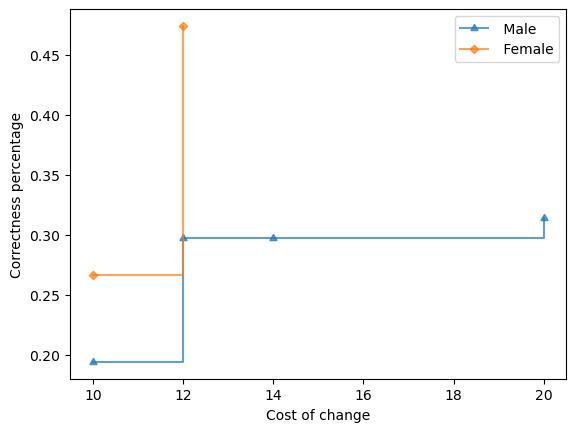

If age = (26.0, 34.0], capital-gain = 0, capital-loss = 0, hours-per-week = FullTime, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Male', 2.54% covered out of 6566
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 18.56% and counterfactual cost = 10.0.
		Make hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 29.34% and counterfactual cost = 12.0.
		Make hours-per-week = BrainDrain, marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 29.34% and counterfactual cost = 14.0.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 31.14% and counterfactual cost = 20.0.
		Aggregate cost of the above recourses = 20.00
	Protected Subgroup ' Female', 3.06% covered out of 4178
		Make marital-status =  Married-civ-spouse, relationship =  Married with effectiveness 25.78% and counter

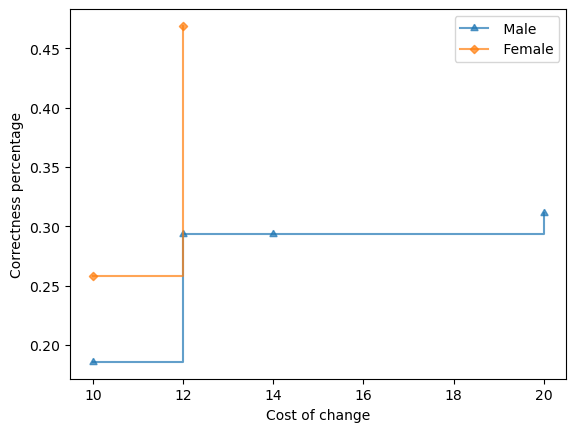

If capital-gain = 0, education-num = 11, hours-per-week = FullTime, race =  White:
	Protected Subgroup ' Male', 1.95% covered out of 6566
		Make hours-per-week = OverTime with effectiveness 32.03% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 2.00
	Protected Subgroup ' Female', 2.01% covered out of 4178
		Make hours-per-week = OverTime with effectiveness 3.57% and counterfactual cost = 2.0.
		Make education-num = 12 with effectiveness 3.57% and counterfactual cost = 3.0.
		Make education-num = 12, hours-per-week = OverTime with effectiveness 3.57% and counterfactual cost = 5.0.
		Make education-num = 13 with effectiveness 3.57% and counterfactual cost = 6.0.
		Make education-num = 13, hours-per-week = MidTime with effectiveness 3.57% and counterfactual cost = 8.0.
		Make education-num = 13, hours-per-week = OverTime with effectiveness 3.57% and counterfactual cost = 8.0.
		Make capital-gain = 15024, education-num = 13, hours-per-week = OverTime with effective

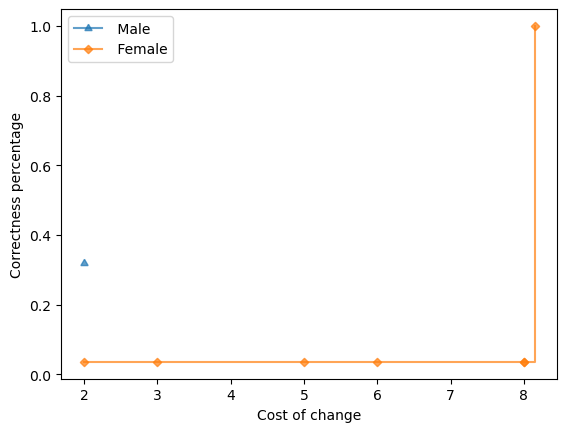

If education-num = 13, marital-status =  Divorced:
	Protected Subgroup ' Male', 1.37% covered out of 6566
		Make marital-status =  Married-civ-spouse with effectiveness 31.11% and counterfactual cost = 5.0.
		Aggregate cost of the above recourses = 5.00
	Protected Subgroup ' Female', 2.63% covered out of 4178
		Make marital-status =  Married-civ-spouse with effectiveness 15.45% and counterfactual cost = 5.0.
		Make education-num = 14, marital-status =  Married-civ-spouse with effectiveness 28.18% and counterfactual cost = 8.0.
		Make education-num = 15, marital-status =  Married-civ-spouse with effectiveness 41.82% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 11.00
	Bias against  Female due to Equal Effectiveness. Unfairness score = 6.0.
	Cumulative effectiveness plot for the above recourses:


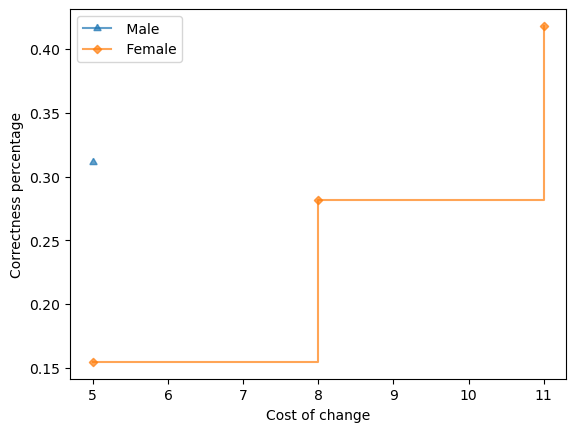

In [22]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="min-above-corr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "keep-cheap-rules-above-thr-cor",
        # "keep-only-min-change",
        
    ],
    cor_threshold = 0.3,
    params=params
)

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

### Equal Effectiveness Within Budget

Dually to the previous metric, here we compute the maximum effectiveness that can be achieved for a given cost "budget". The subgroups are then ranked according to the difference between Males and Females in descending order.

If capital-gain = 0, education-num = 9, hours-per-week = FullTime, native-country =  United-States, occupation =  Exec-managerial:
	Protected Subgroup ' Male', 1.02% covered out of 6566
		Make hours-per-week = OverTime with effectiveness 43.28% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 43.28% and counterfactual cost = 3.0.
		Make education-num = 10, hours-per-week = OverTime with effectiveness 65.67% and counterfactual cost = 5.0.
		Make education-num = 10, hours-per-week = OverTime, occupation =  Sales with effectiveness 65.67% and counterfactual cost = 9.0.
		Aggregate cost of the above recourses = 0.66
	Protected Subgroup ' Female', 1.53% covered out of 4178
		Make hours-per-week = OverTime with effectiveness 7.81% and counterfactual cost = 2.0.
		Make education-num = 10 with effectiveness 7.81% and counterfactual cost = 3.0.
		Make education-num = 10, hours-per-week = OverTime with effectiveness 7.81% and counterfactual cost = 5.0.
		Make education

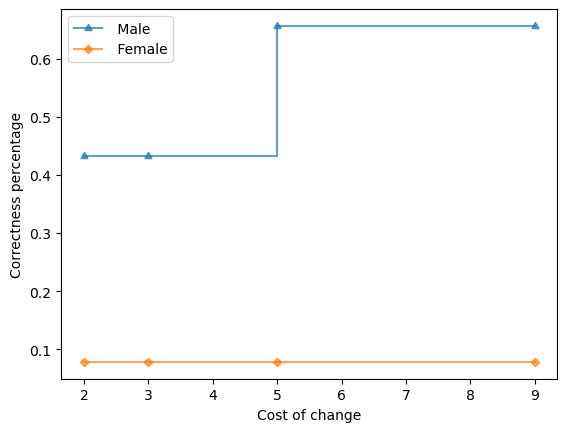

If capital-loss = 0, education-num = 10, hours-per-week = FullTime, native-country =  United-States, occupation =  Sales:
	Protected Subgroup ' Male', 1.04% covered out of 6566
		Make hours-per-week = OverTime with effectiveness 33.82% and counterfactual cost = 2.0.
		Make occupation =  Exec-managerial with effectiveness 33.82% and counterfactual cost = 4.0.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 54.41% and counterfactual cost = 6.0.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with effectiveness 54.41% and counterfactual cost = 8.0.
		Aggregate cost of the above recourses = 0.54
	Protected Subgroup ' Female', 1.05% covered out of 4178
		Make hours-per-week = OverTime with effectiveness 4.55% and counterfactual cost = 2.0.
		Make occupation =  Exec-managerial with effectiveness 4.55% and counterfactual cost = 4.0.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 4.55% and counterfactual c

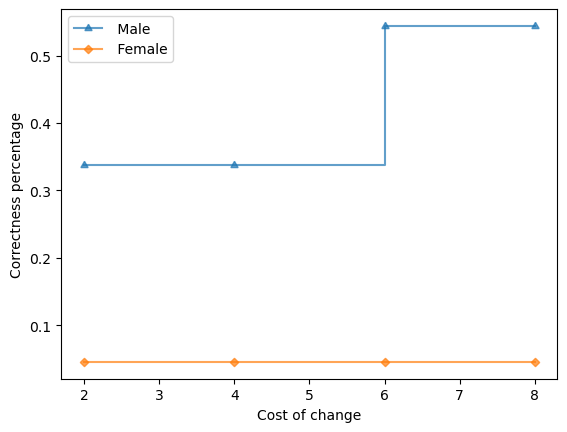

If Workclass =  Private, age = (41.0, 50.0], occupation =  Machine-op-inspct:
	Protected Subgroup ' Male', 1.45% covered out of 6566
		Make occupation =  Craft-repair with effectiveness 9.47% and counterfactual cost = 4.0.
		Make occupation =  Adm-clerical with effectiveness 11.58% and counterfactual cost = 4.0.
		Make occupation =  Sales with effectiveness 23.16% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 29.47% and counterfactual cost = 4.0.
		Make occupation =  Tech-support with effectiveness 29.47% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 46.32% and counterfactual cost = 4.0.
		Make Workclass =  Self-emp-not-inc, occupation =  Prof-specialty with effectiveness 46.32% and counterfactual cost = 6.0.
		Make Workclass =  State-gov, occupation =  Prof-specialty with effectiveness 46.32% and counterfactual cost = 6.0.
		Make Workclass =  Local-gov, occupation =  Prof-specialty with effectiveness 46.3

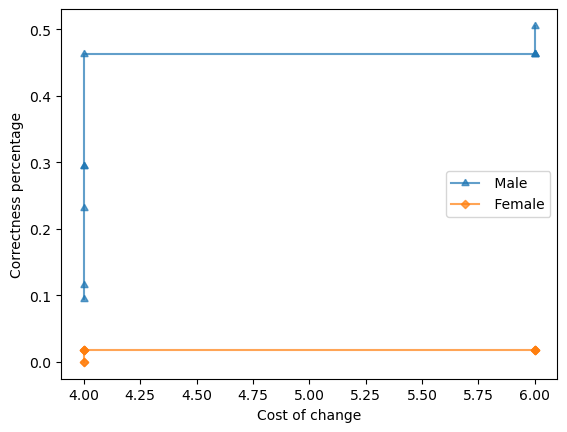

If age = (41.0, 50.0], native-country =  United-States, occupation =  Machine-op-inspct:
	Protected Subgroup ' Male', 1.29% covered out of 6566
		Make occupation =  Craft-repair with effectiveness 7.06% and counterfactual cost = 4.0.
		Make occupation =  Adm-clerical with effectiveness 10.59% and counterfactual cost = 4.0.
		Make occupation =  Sales with effectiveness 22.35% and counterfactual cost = 4.0.
		Make occupation =  Prof-specialty with effectiveness 29.41% and counterfactual cost = 4.0.
		Make occupation =  Tech-support with effectiveness 29.41% and counterfactual cost = 4.0.
		Make occupation =  Exec-managerial with effectiveness 48.24% and counterfactual cost = 4.0.
		Aggregate cost of the above recourses = 0.48
	Protected Subgroup ' Female', 1.05% covered out of 4178
		Make occupation =  Craft-repair with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Adm-clerical with effectiveness 0.00% and counterfactual cost = 4.0.
		Make occupation =  Exec-man

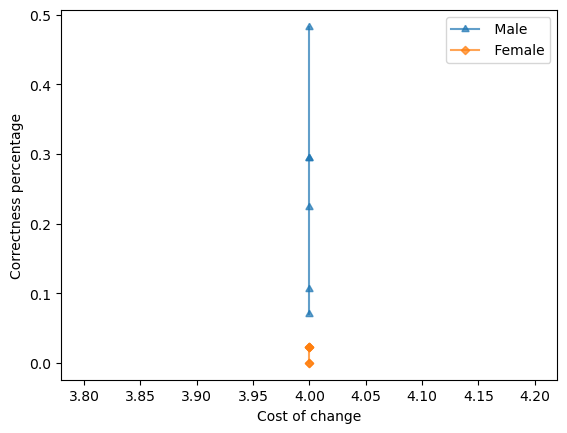

If capital-gain = 0, capital-loss = 0, education-num = 9, hours-per-week = FullTime, native-country =  United-States, occupation =  Sales:
	Protected Subgroup ' Male', 1.25% covered out of 6566
		Make education-num = 10, hours-per-week = OverTime with effectiveness 35.37% and counterfactual cost = 5.0.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 36.59% and counterfactual cost = 6.0.
		Make education-num = 10, occupation =  Exec-managerial with effectiveness 36.59% and counterfactual cost = 7.0.
		Make education-num = 10, hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 52.44% and counterfactual cost = 9.0.
		Aggregate cost of the above recourses = 0.52
	Protected Subgroup ' Female', 1.10% covered out of 4178
		Make education-num = 10, hours-per-week = OverTime with effectiveness 6.52% and counterfactual cost = 5.0.
		Make hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 6.52% and counterfactual

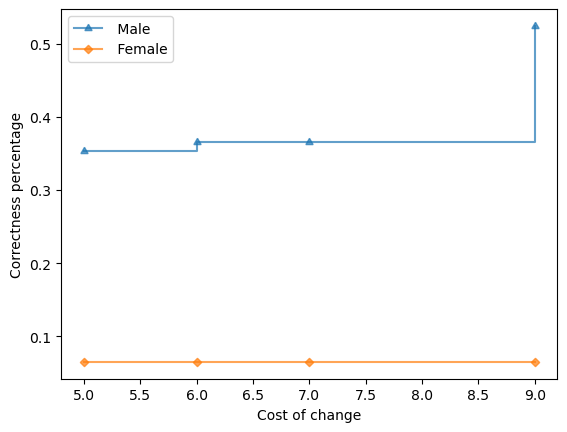

If Workclass =  Private, capital-gain = 0, education-num = 9, hours-per-week = FullTime, native-country =  United-States, occupation =  Machine-op-inspct, race =  White:
	Protected Subgroup ' Male', 2.28% covered out of 6566
		Make hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 40.00% and counterfactual cost = 6.0.
		Make education-num = 10, hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 54.00% and counterfactual cost = 9.0.
		Aggregate cost of the above recourses = 0.54
	Protected Subgroup ' Female', 1.17% covered out of 4178
		Make hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 8.16% and counterfactual cost = 6.0.
		Make education-num = 10, hours-per-week = OverTime, occupation =  Exec-managerial with effectiveness 8.16% and counterfactual cost = 9.0.
		Aggregate cost of the above recourses = 0.08
	Bias against  Female due to Equal Effectiveness. Unfairness score = 0.458.
	Cumulative effectiveness 

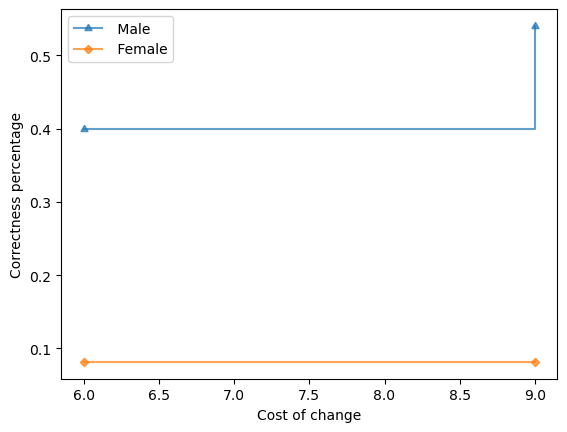

In [23]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="max-upto-cost",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "remove-above-thr-cost"
        #"remove-below-thr",
        #"keep-only-min-change",
        
    ],
    cost_threshold = 10,
    params=params
)

pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric = True
)

### Fair Effectiveness-Cost Trade-Off

Here, we compare more directly the two "cumulative density functions" for Males and Females, using the 2-point Kolmogorov-Smirnoff test.

If capital-gain = 0, capital-loss = 0:
	Protected Subgroup ' Male', 93.88% covered out of 6566
		Make capital-gain = 3103 with effectiveness 25.42% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 34.28% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 39.28% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 50.89% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 52.81% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 83.16% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 83.16% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 83.16% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 83.16% and counterfactual cost = 0.45.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
	Protected Subgroup ' Female', 93.56% covered out of 

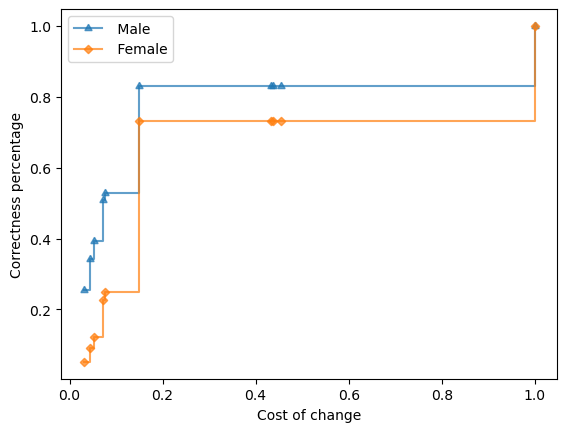

If capital-gain = 0:
	Protected Subgroup ' Male', 96.57% covered out of 6566
		Make capital-gain = 3103 with effectiveness 25.82% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 34.90% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 39.87% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 51.46% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 53.38% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 83.49% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
	Protected Subgroup ' Female', 96.53% covered out of 4178
		Make capital-gain = 3103 with effectiveness 5.65% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 9.89% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 12.94% and counterfactual cost = 0.05.
		Make capital-

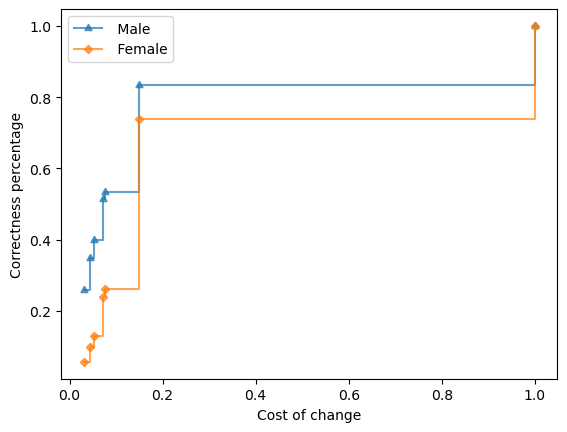

If capital-gain = 0, capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Male', 84.62% covered out of 6566
		Make capital-gain = 3103 with effectiveness 26.62% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 35.76% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 40.93% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 52.57% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 54.48% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 84.09% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 84.09% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 84.09% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 84.09% and counterfactual cost = 0.45.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
	Protected Subgroup 

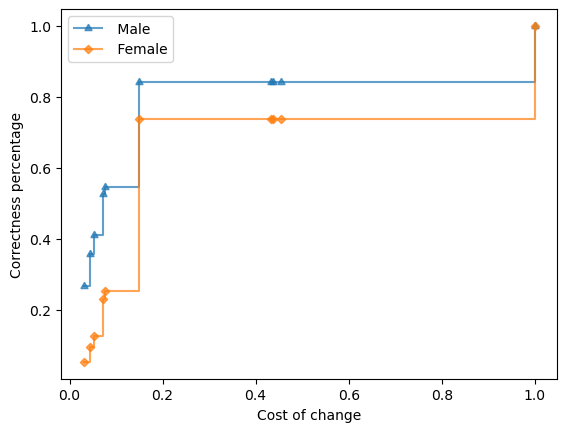

If capital-gain = 0, native-country =  United-States:
	Protected Subgroup ' Male', 87.21% covered out of 6566
		Make capital-gain = 3103 with effectiveness 27.03% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 36.38% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 41.51% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 53.13% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 55.05% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 84.42% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
	Protected Subgroup ' Female', 87.67% covered out of 4178
		Make capital-gain = 3103 with effectiveness 5.76% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 10.16% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 13.30% and counterfa

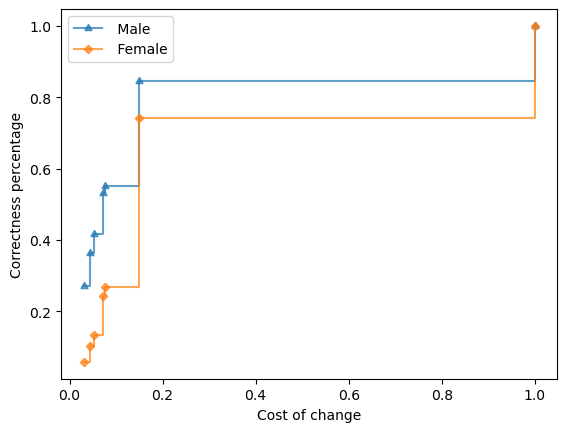

If capital-gain = 0, capital-loss = 0, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 74.86% covered out of 6566
		Make capital-gain = 3103 with effectiveness 28.06% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 37.72% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 42.79% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 54.47% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 56.36% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 84.84% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 84.84% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 84.84% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 84.84% and counterfactual cost = 0.45.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Mak

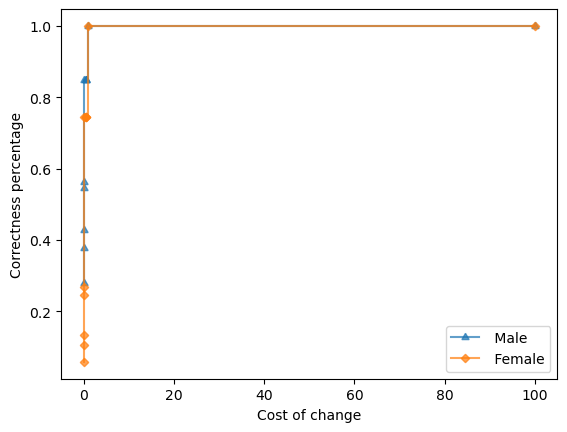

If capital-gain = 0, capital-loss = 0, race =  White:
	Protected Subgroup ' Male', 81.25% covered out of 6566
		Make capital-gain = 3103 with effectiveness 26.92% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 36.25% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 41.11% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 52.69% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 54.60% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 83.86% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 83.86% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 83.86% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 83.86% and counterfactual cost = 0.45.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make race =  Asian-Pac-Islander with

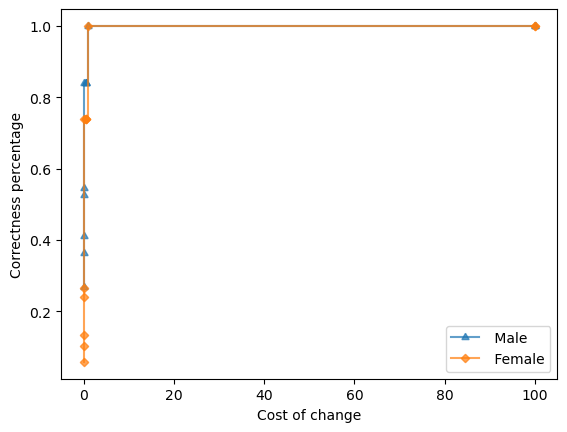

If capital-gain = 0, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 77.12% covered out of 6566
		Make capital-gain = 3103 with effectiveness 28.46% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 38.31% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 43.35% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 55.02% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 56.93% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 85.17% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make race =  Black with effectiveness 100.00% and counterfactual cost = 100.0.
	Protected Subgroup ' Female', 71.54% covered out of 4178
		Make capital-gain = 3103 with effectiveness 6.36% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 11.21% an

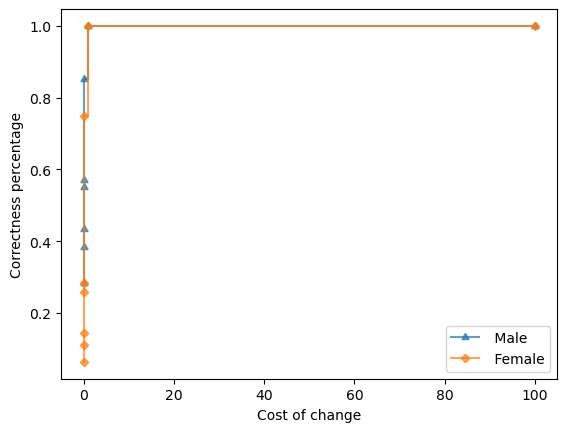

If capital-gain = 0, race =  White:
	Protected Subgroup ' Male', 83.58% covered out of 6566
		Make capital-gain = 3103 with effectiveness 27.31% and counterfactual cost = 0.03.
		Make capital-gain = 4386 with effectiveness 36.84% and counterfactual cost = 0.04.
		Make capital-gain = 5178 with effectiveness 41.67% and counterfactual cost = 0.05.
		Make capital-gain = 7298 with effectiveness 53.24% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 55.17% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 84.18% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make race =  Asian-Pac-Islander with effectiveness 100.00% and counterfactual cost = 100.0.
		Make race =  Black with effectiveness 100.00% and counterfactual cost = 100.0.
	Protected Subgroup ' Female', 76.97% covered out of 4178
		Make capital-gain = 3103 with effectiveness 6.28% and counterfactual cost = 

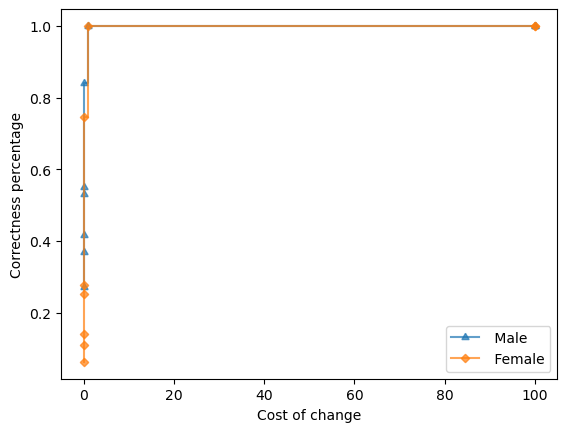

If Workclass =  Private, capital-gain = 0, capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Male', 63.65% covered out of 6566
		Make capital-gain = 7298 with effectiveness 48.86% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 50.63% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 81.38% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 81.38% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 81.38% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 81.38% and counterfactual cost = 0.45.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make Workclass =  Local-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 100.00% and counterfa

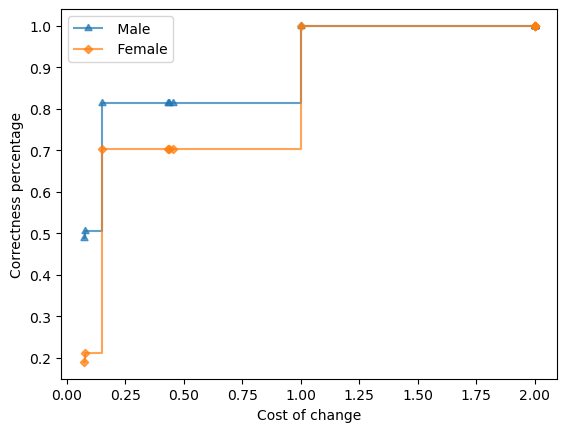

If Workclass =  Private, capital-gain = 0, native-country =  United-States:
	Protected Subgroup ' Male', 65.60% covered out of 6566
		Make capital-gain = 7298 with effectiveness 49.45% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 51.24% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 81.77% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make Workclass =  Local-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 100.00% and counterfactual cost = 2.0.
	Protected Subgroup ' Female', 69.08% covered out of 4178
		Make capital-g

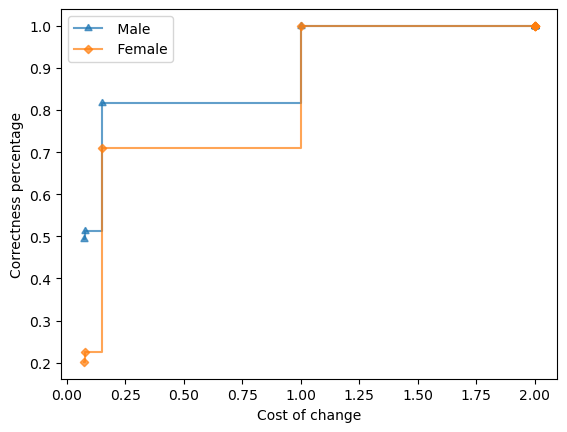

If Workclass =  Private, capital-gain = 0, capital-loss = 0:
	Protected Subgroup ' Male', 71.63% covered out of 6566
		Make capital-gain = 7298 with effectiveness 46.82% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 48.61% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 80.27% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 80.27% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 80.27% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 80.27% and counterfactual cost = 0.45.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make Workclass =  Local-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclas

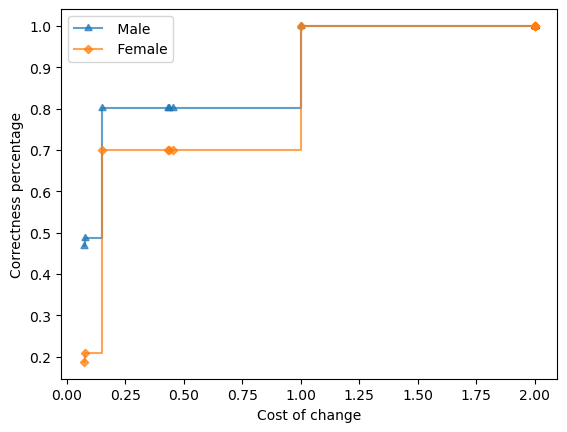

If Workclass =  Private, capital-gain = 0:
	Protected Subgroup ' Male', 73.64% covered out of 6566
		Make capital-gain = 7298 with effectiveness 47.40% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 49.20% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 80.64% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make Workclass =  Local-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 100.00% and counterfactual cost = 2.0.
	Protected Subgroup ' Female', 76.35% covered out of 4178
		Make capital-gain = 7298 with effectiveness 19.

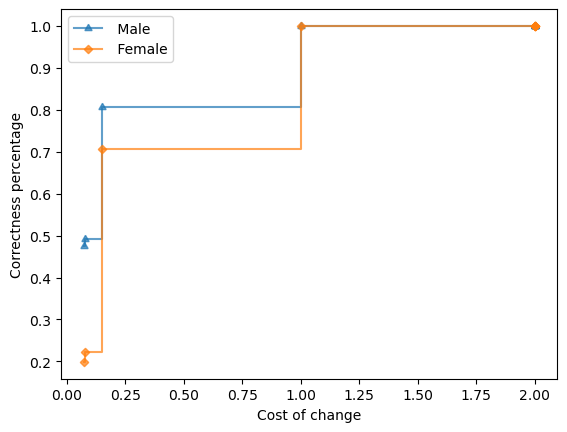

If Workclass =  Private, capital-gain = 0, capital-loss = 0, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 56.29% covered out of 6566
		Make capital-gain = 7298 with effectiveness 50.73% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 52.52% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 82.14% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 82.14% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 82.14% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 82.14% and counterfactual cost = 0.45.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make Workclass =  Local-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 100.00

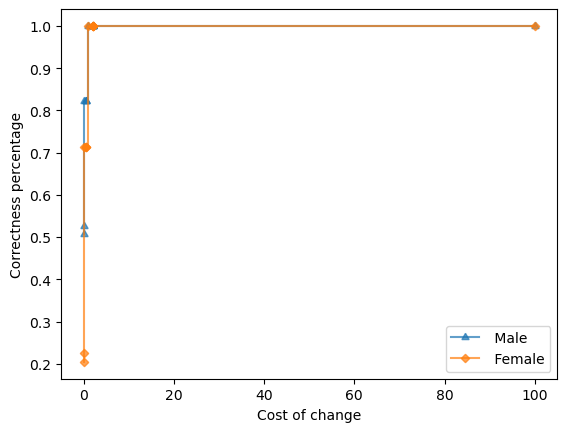

If Workclass =  Private, capital-gain = 0, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 57.97% covered out of 6566
		Make capital-gain = 7298 with effectiveness 51.29% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 53.10% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 82.53% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make Workclass =  Local-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make race =  Black with effectiveness 100.00% and counter

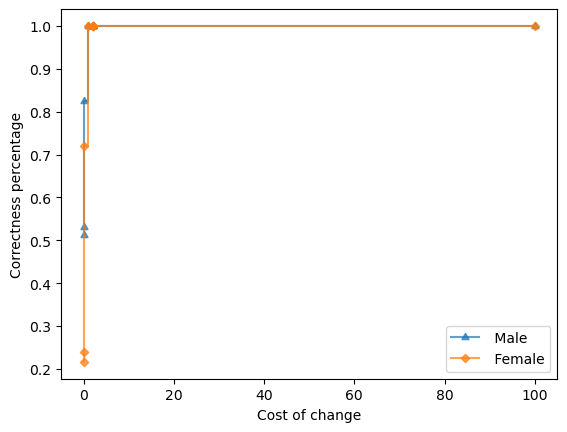

If Workclass =  Private, capital-gain = 0, capital-loss = 0, race =  White:
	Protected Subgroup ' Male', 61.79% covered out of 6566
		Make capital-gain = 7298 with effectiveness 48.56% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 50.36% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 80.95% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 80.95% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 80.95% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 80.95% and counterfactual cost = 0.45.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make Workclass =  Local-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 100.00% and counterfactual cost = 2.0.


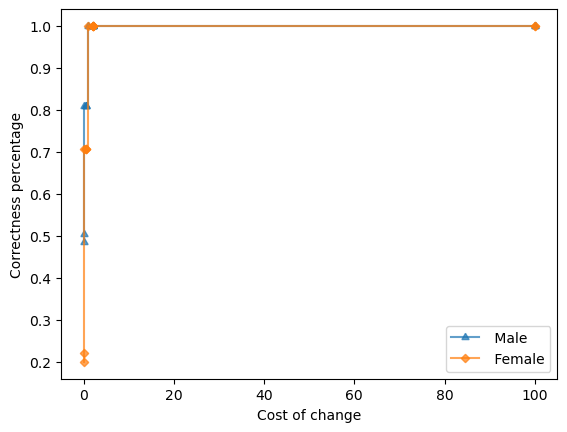

If Workclass =  Private, capital-gain = 0, race =  White:
	Protected Subgroup ' Male', 63.49% covered out of 6566
		Make capital-gain = 7298 with effectiveness 49.10% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 50.92% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 81.31% and counterfactual cost = 0.15.
		Make capital-gain = 99999 with effectiveness 100.00% and counterfactual cost = 1.0.
		Make Workclass =  Local-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 100.00% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 100.00% and counterfactual cost = 2.0.
		Make race =  Asian-Pac-Islander with effectiveness 100.00% and counterfactual cost = 100.0

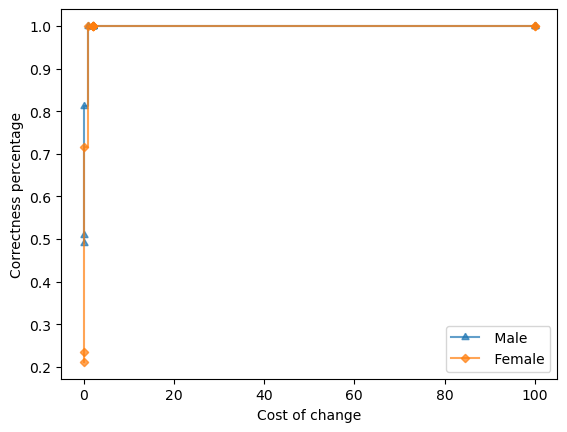

If capital-loss = 0:
	Protected Subgroup ' Male', 97.30% covered out of 6566
		Make capital-loss = 1887 with effectiveness 29.41% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 29.57% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 30.33% and counterfactual cost = 0.45.
	Protected Subgroup ' Female', 97.03% covered out of 4178
		Make capital-loss = 1887 with effectiveness 7.42% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 7.60% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 7.99% and counterfactual cost = 0.45.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 11.13.
	Cumulative effectiveness plot for the above recourses:


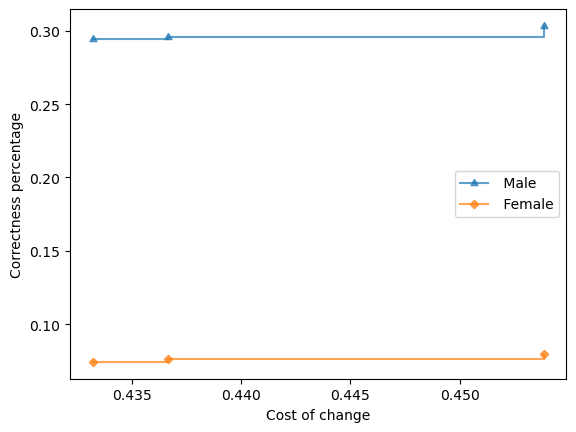

If capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Male', 87.63% covered out of 6566
		Make capital-loss = 1887 with effectiveness 30.67% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 30.85% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 31.63% and counterfactual cost = 0.45.
	Protected Subgroup ' Female', 88.30% covered out of 4178
		Make capital-loss = 1887 with effectiveness 7.67% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 7.86% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 8.29% and counterfactual cost = 0.45.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 11.06.
	Cumulative effectiveness plot for the above recourses:


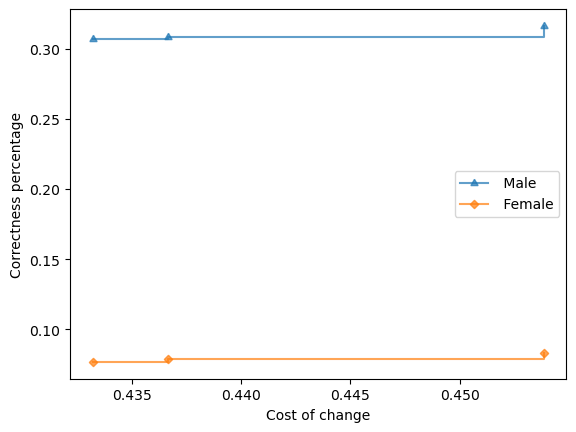

If capital-loss = 0, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 77.52% covered out of 6566
		Make capital-loss = 1887 with effectiveness 32.20% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 32.40% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 33.20% and counterfactual cost = 0.45.
		Make race =  Black with effectiveness 33.20% and counterfactual cost = 100.0.
	Protected Subgroup ' Female', 71.76% covered out of 4178
		Make capital-loss = 1887 with effectiveness 8.44% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 8.64% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 9.07% and counterfactual cost = 0.45.
		Make race =  Black with effectiveness 9.07% and counterfactual cost = 100.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 10.48.
	Cumulative effectiveness plot for the above recourses:


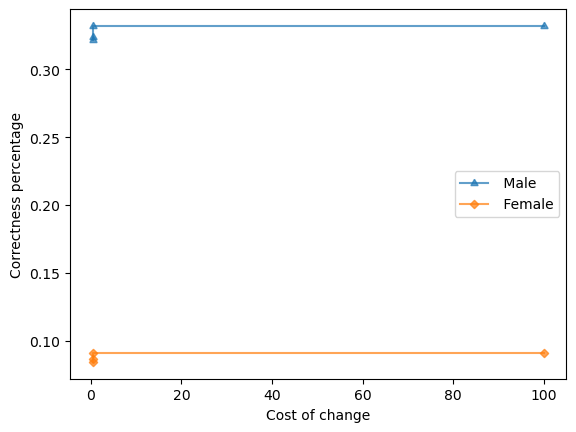

If capital-loss = 0, race =  White:
	Protected Subgroup ' Male', 84.19% covered out of 6566
		Make capital-loss = 1887 with effectiveness 30.93% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 31.11% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 31.93% and counterfactual cost = 0.45.
		Make race =  Asian-Pac-Islander with effectiveness 31.93% and counterfactual cost = 100.0.
		Make race =  Black with effectiveness 31.93% and counterfactual cost = 100.0.
	Protected Subgroup ' Female', 77.09% covered out of 4178
		Make capital-loss = 1887 with effectiveness 8.26% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 8.44% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 8.85% and counterfactual cost = 0.45.
		Make race =  Asian-Pac-Islander with effectiveness 8.85% and counterfactual cost = 100.0.
		Make race =  Black with effectiveness 8.85% and counterfactual cost = 100.0.

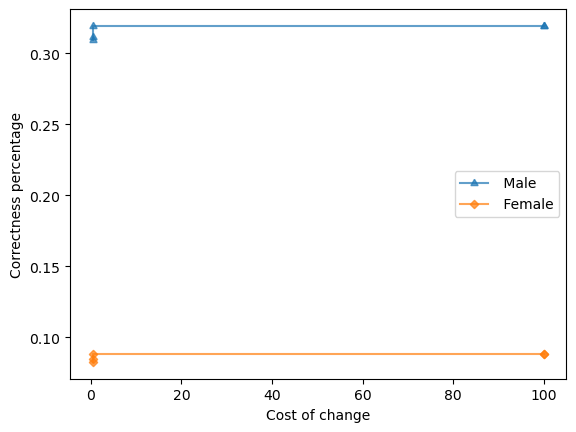

If capital-gain = 0, capital-loss = 0, hours-per-week = FullTime:
	Protected Subgroup ' Male', 49.39% covered out of 6566
		Make capital-gain = 7298 with effectiveness 51.68% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 53.53% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 86.34% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 86.34% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 86.34% and counterfactual cost = 0.44.
		Make hours-per-week = MidTime with effectiveness 86.34% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 86.34% and counterfactual cost = 2.0.
		Make capital-gain = 7298, hours-per-week = OverTime with effectiveness 86.34% and counterfactual cost = 2.07.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 86.34% and counterfactual cost = 2.08.
		Make capital-gain = 15024, hours-per-week = Ove

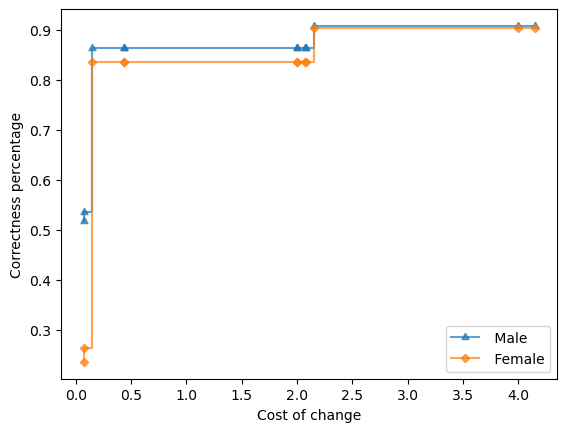

If capital-gain = 0, capital-loss = 0, hours-per-week = FullTime, native-country =  United-States:
	Protected Subgroup ' Male', 43.83% covered out of 6566
		Make capital-gain = 7298 with effectiveness 53.58% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 55.42% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 87.32% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 87.32% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 87.32% and counterfactual cost = 0.44.
		Make hours-per-week = MidTime with effectiveness 87.32% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 87.32% and counterfactual cost = 2.0.
		Make capital-gain = 7298, hours-per-week = OverTime with effectiveness 87.32% and counterfactual cost = 2.07.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 87.32% and counterfactual cost = 2.08.
		Make capital-g

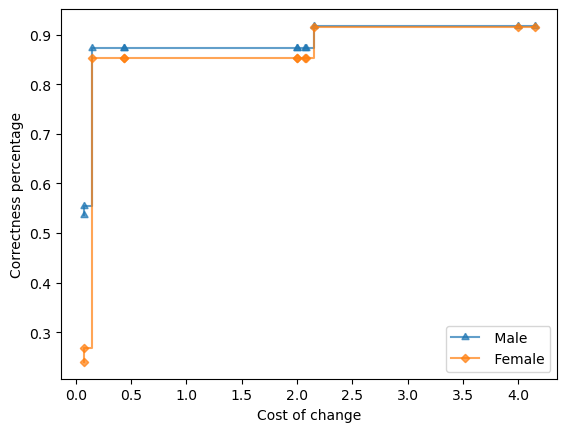

If capital-gain = 0, hours-per-week = FullTime:
	Protected Subgroup ' Male', 50.64% covered out of 6566
		Make capital-gain = 7298 with effectiveness 52.15% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 54.02% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 86.62% and counterfactual cost = 0.15.
		Make hours-per-week = MidTime with effectiveness 86.62% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 86.62% and counterfactual cost = 2.0.
		Make capital-gain = 7298, hours-per-week = OverTime with effectiveness 86.62% and counterfactual cost = 2.07.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 86.62% and counterfactual cost = 2.08.
		Make capital-gain = 15024, hours-per-week = OverTime with effectiveness 90.92% and counterfactual cost = 2.15.
		Make hours-per-week = BrainDrain with effectiveness 90.92% and counterfactual cost = 4.0.
		Make capital-gain = 15024, hou

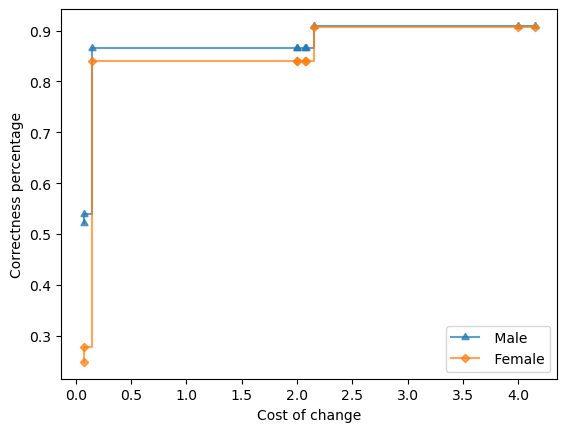

If capital-gain = 0, hours-per-week = FullTime, native-country =  United-States:
	Protected Subgroup ' Male', 45.00% covered out of 6566
		Make capital-gain = 7298 with effectiveness 54.04% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 55.91% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 87.61% and counterfactual cost = 0.15.
		Make hours-per-week = MidTime with effectiveness 87.61% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 87.61% and counterfactual cost = 2.0.
		Make capital-gain = 7298, hours-per-week = OverTime with effectiveness 87.61% and counterfactual cost = 2.07.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 87.61% and counterfactual cost = 2.08.
		Make capital-gain = 15024, hours-per-week = OverTime with effectiveness 91.95% and counterfactual cost = 2.15.
		Make hours-per-week = BrainDrain with effectiveness 91.95% and counterfactual cost = 4.0.

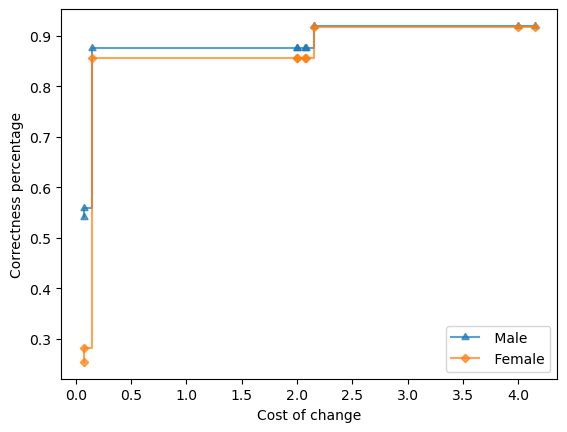

If Workclass =  Private, capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Male', 65.81% covered out of 6566
		Make capital-loss = 1887 with effectiveness 28.42% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 28.51% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 29.14% and counterfactual cost = 0.45.
		Make Workclass =  Local-gov with effectiveness 29.14% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 29.14% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 29.14% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 29.14% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 29.14% and counterfactual cost = 2.0.
	Protected Subgroup ' Female', 69.70% covered out of 4178
		Make capital-loss = 1887 with effectiveness 6.28% and counterfactual cost = 0.43.
		Make capital-loss = 19

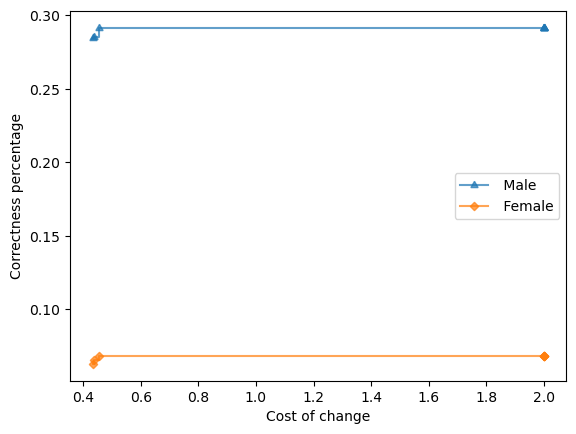

If Workclass =  Private, capital-loss = 0:
	Protected Subgroup ' Male', 74.08% covered out of 6566
		Make capital-loss = 1887 with effectiveness 26.97% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 27.06% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 27.67% and counterfactual cost = 0.45.
		Make Workclass =  Local-gov with effectiveness 27.67% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 27.67% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 27.67% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 27.67% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 27.67% and counterfactual cost = 2.0.
	Protected Subgroup ' Female', 76.88% covered out of 4178
		Make capital-loss = 1887 with effectiveness 6.10% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 6.32% and c

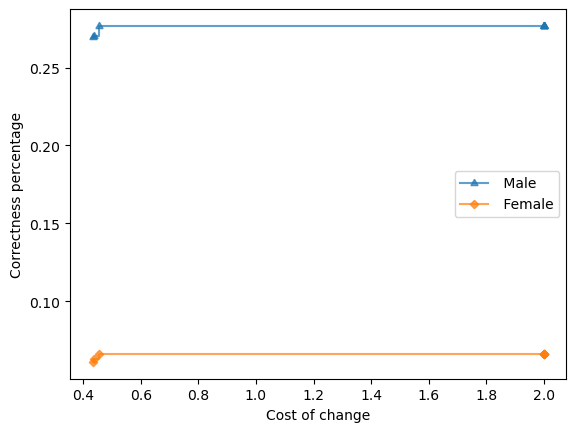

If Workclass =  Private, capital-loss = 0, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 58.21% covered out of 6566
		Make capital-loss = 1887 with effectiveness 29.96% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 30.06% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 30.66% and counterfactual cost = 0.45.
		Make Workclass =  Local-gov with effectiveness 30.66% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 30.66% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 30.66% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 30.66% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 30.66% and counterfactual cost = 2.0.
		Make race =  Black with effectiveness 30.66% and counterfactual cost = 100.0.
	Protected Subgroup ' Female', 57.54% covered out of 4178
		Make capita

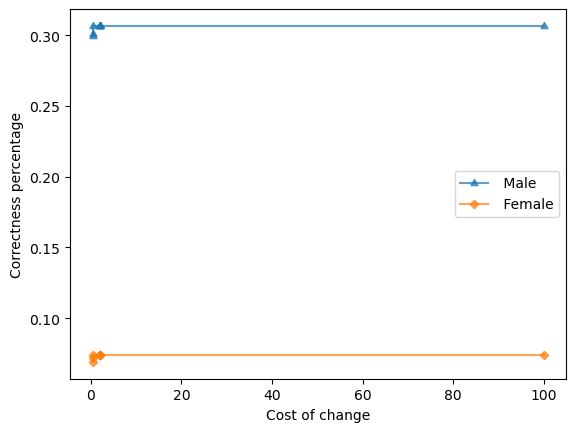

If Workclass =  Private, capital-loss = 0, race =  White:
	Protected Subgroup ' Male', 63.89% covered out of 6566
		Make capital-loss = 1887 with effectiveness 28.46% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 28.56% and counterfactual cost = 0.44.
		Make capital-loss = 1977 with effectiveness 29.18% and counterfactual cost = 0.45.
		Make Workclass =  Local-gov with effectiveness 29.18% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 29.18% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 29.18% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 29.18% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 29.18% and counterfactual cost = 2.0.
		Make race =  Black with effectiveness 29.18% and counterfactual cost = 100.0.
		Make race =  Asian-Pac-Islander with effectiveness 29.18% and counterfactual cost = 100.0.
	Protected 

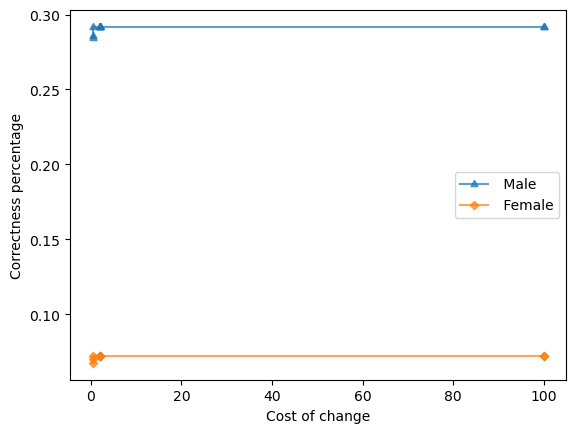

If capital-gain = 0, capital-loss = 0, hours-per-week = FullTime, race =  White:
	Protected Subgroup ' Male', 41.18% covered out of 6566
		Make capital-gain = 7298 with effectiveness 53.55% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 55.44% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 87.06% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 87.06% and counterfactual cost = 0.43.
		Make hours-per-week = MidTime with effectiveness 87.06% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 87.06% and counterfactual cost = 2.0.
		Make capital-gain = 7298, hours-per-week = OverTime with effectiveness 87.06% and counterfactual cost = 2.07.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 87.06% and counterfactual cost = 2.08.
		Make capital-gain = 15024, hours-per-week = OverTime with effectiveness 91.53% and counterfactual cost = 2.15.
		Make

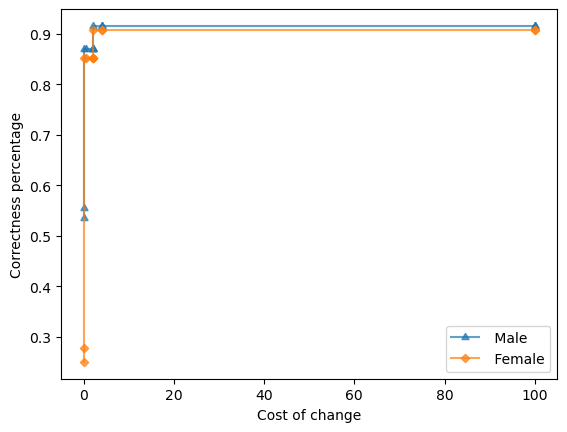

If capital-gain = 0, capital-loss = 0, hours-per-week = FullTime, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 37.45% covered out of 6566
		Make capital-gain = 7298 with effectiveness 55.75% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 57.58% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 88.13% and counterfactual cost = 0.15.
		Make capital-loss = 1887 with effectiveness 88.13% and counterfactual cost = 0.43.
		Make hours-per-week = MidTime with effectiveness 88.13% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 88.13% and counterfactual cost = 2.0.
		Make capital-gain = 7298, hours-per-week = OverTime with effectiveness 88.13% and counterfactual cost = 2.07.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 88.13% and counterfactual cost = 2.08.
		Make capital-gain = 15024, hours-per-week = OverTime with effectiveness 92.56% and c

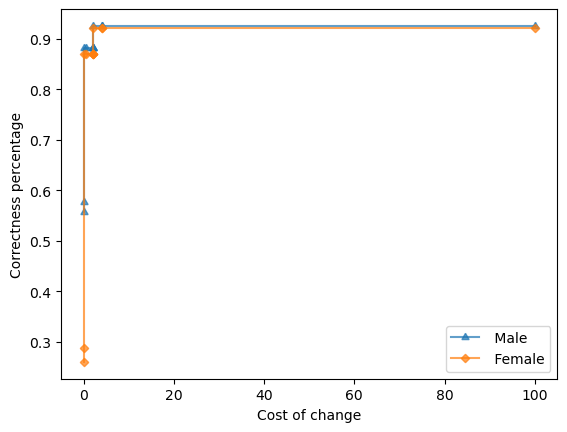

If capital-gain = 0, hours-per-week = FullTime, race =  White:
	Protected Subgroup ' Male', 42.22% covered out of 6566
		Make capital-gain = 7298 with effectiveness 53.97% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 55.88% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 87.30% and counterfactual cost = 0.15.
		Make hours-per-week = MidTime with effectiveness 87.30% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 87.30% and counterfactual cost = 2.0.
		Make capital-gain = 7298, hours-per-week = OverTime with effectiveness 87.30% and counterfactual cost = 2.07.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 87.30% and counterfactual cost = 2.08.
		Make capital-gain = 15024, hours-per-week = OverTime with effectiveness 91.67% and counterfactual cost = 2.15.
		Make hours-per-week = BrainDrain with effectiveness 91.67% and counterfactual cost = 4.0.
		Make capital-ga

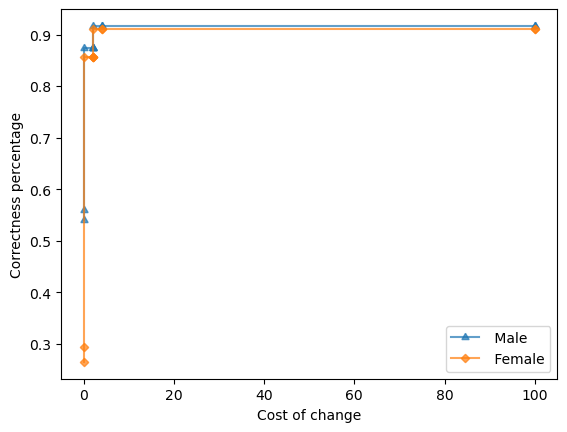

If capital-gain = 0, hours-per-week = FullTime, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 38.44% covered out of 6566
		Make capital-gain = 7298 with effectiveness 56.18% and counterfactual cost = 0.07.
		Make capital-gain = 7688 with effectiveness 58.04% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 88.39% and counterfactual cost = 0.15.
		Make hours-per-week = MidTime with effectiveness 88.39% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 88.39% and counterfactual cost = 2.0.
		Make capital-gain = 7298, hours-per-week = OverTime with effectiveness 88.39% and counterfactual cost = 2.07.
		Make capital-gain = 7688, hours-per-week = OverTime with effectiveness 88.39% and counterfactual cost = 2.08.
		Make capital-gain = 15024, hours-per-week = OverTime with effectiveness 92.71% and counterfactual cost = 2.15.
		Make hours-per-week = BrainDrain with effectiveness 92.71% and counterfact

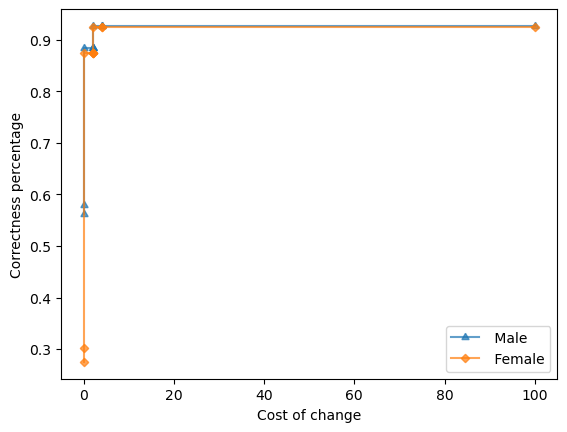

If Workclass =  Private, capital-gain = 0, capital-loss = 0, hours-per-week = FullTime:
	Protected Subgroup ' Male', 39.52% covered out of 6566
		Make capital-gain = 7688 with effectiveness 50.52% and counterfactual cost = 0.08.
		Make Workclass =  Local-gov with effectiveness 50.52% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 50.52% and counterfactual cost = 2.0.
		Make hours-per-week = MidTime with effectiveness 50.52% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 50.52% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 50.52% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 50.52% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 50.52% and counterfactual cost = 2.0.
		Make capital-gain = 15024, hours-per-week = OverTime with effectiveness 89.63% and counterfactual cost = 2.15.
		Make Workclass =  Self-emp-not

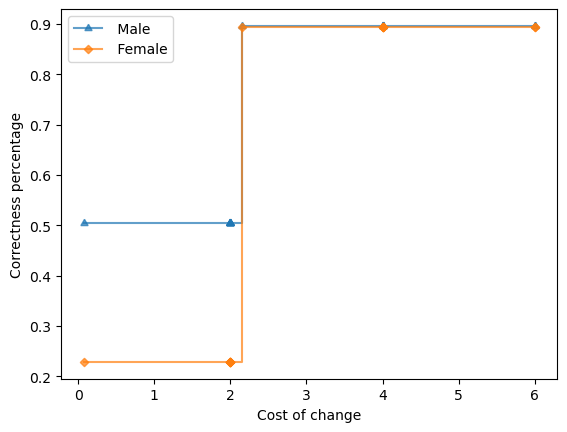

If age = (50.0, 90.0], capital-gain = 0, capital-loss = 0:
	Protected Subgroup ' Male', 16.78% covered out of 6566
		Make capital-gain = 7688 with effectiveness 74.32% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 97.82% and counterfactual cost = 0.15.
	Protected Subgroup ' Female', 15.77% covered out of 4178
		Make capital-gain = 7688 with effectiveness 32.93% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 89.83% and counterfactual cost = 0.15.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 8.41.
	Cumulative effectiveness plot for the above recourses:


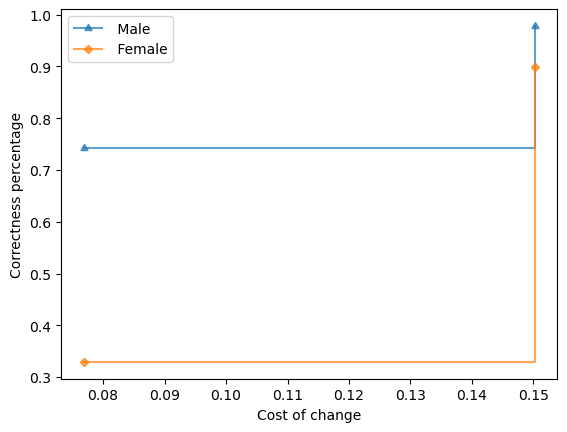

If Workclass =  Private, capital-gain = 0, hours-per-week = FullTime:
	Protected Subgroup ' Male', 40.56% covered out of 6566
		Make capital-gain = 7688 with effectiveness 51.11% and counterfactual cost = 0.08.
		Make Workclass =  Local-gov with effectiveness 51.11% and counterfactual cost = 2.0.
		Make hours-per-week = MidTime with effectiveness 51.11% and counterfactual cost = 2.0.
		Make Workclass =  State-gov with effectiveness 51.11% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-not-inc with effectiveness 51.11% and counterfactual cost = 2.0.
		Make Workclass =  Self-emp-inc with effectiveness 51.11% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 51.11% and counterfactual cost = 2.0.
		Make Workclass =  Federal-gov with effectiveness 51.11% and counterfactual cost = 2.0.
		Make capital-gain = 15024, hours-per-week = OverTime with effectiveness 89.82% and counterfactual cost = 2.15.
		Make Workclass =  Self-emp-not-inc, hours-per-we

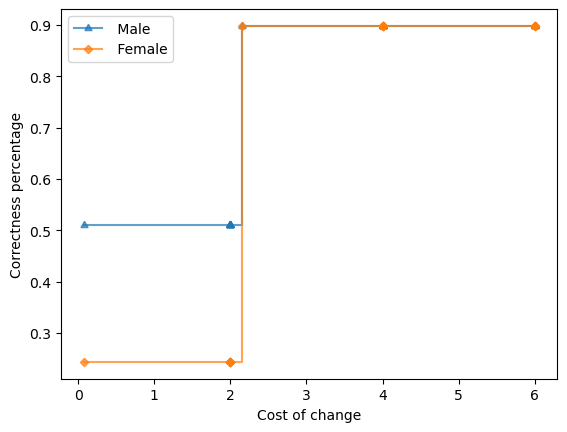

If age = (50.0, 90.0], capital-gain = 0:
	Protected Subgroup ' Male', 17.35% covered out of 6566
		Make capital-gain = 7688 with effectiveness 74.89% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 97.89% and counterfactual cost = 0.15.
	Protected Subgroup ' Female', 16.47% covered out of 4178
		Make capital-gain = 7688 with effectiveness 35.03% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 90.26% and counterfactual cost = 0.15.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 8.26.
	Cumulative effectiveness plot for the above recourses:


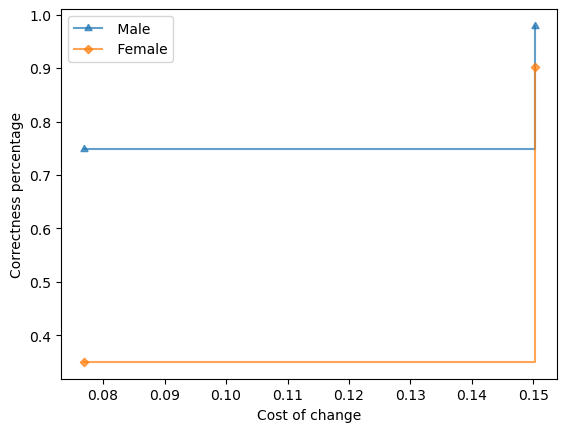

If age = (41.0, 50.0], capital-loss = 0:
	Protected Subgroup ' Male', 15.11% covered out of 6566
		Make capital-loss = 1902 with effectiveness 51.81% and counterfactual cost = 0.44.
		Make age = (50.0, 90.0] with effectiveness 51.81% and counterfactual cost = 10.0.
	Protected Subgroup ' Female', 16.06% covered out of 4178
		Make capital-loss = 1902 with effectiveness 12.52% and counterfactual cost = 0.44.
		Make age = (50.0, 90.0] with effectiveness 12.52% and counterfactual cost = 10.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 7.86.
	Cumulative effectiveness plot for the above recourses:


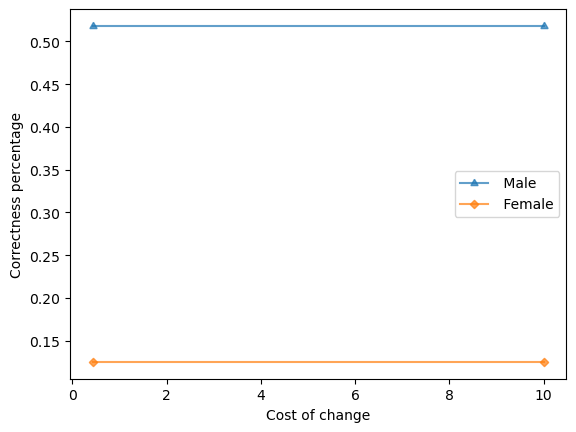

If capital-loss = 0, hours-per-week = FullTime:
	Protected Subgroup ' Male', 51.07% covered out of 6566
		Make capital-loss = 1887 with effectiveness 29.23% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 29.38% and counterfactual cost = 0.44.
		Make hours-per-week = MidTime with effectiveness 29.38% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 29.38% and counterfactual cost = 2.0.
		Make hours-per-week = PartTime with effectiveness 29.38% and counterfactual cost = 4.0.
		Make hours-per-week = BrainDrain with effectiveness 29.38% and counterfactual cost = 4.0.
	Protected Subgroup ' Female', 46.12% covered out of 4178
		Make capital-loss = 1887 with effectiveness 6.90% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 6.95% and counterfactual cost = 0.44.
		Make hours-per-week = MidTime with effectiveness 6.95% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness

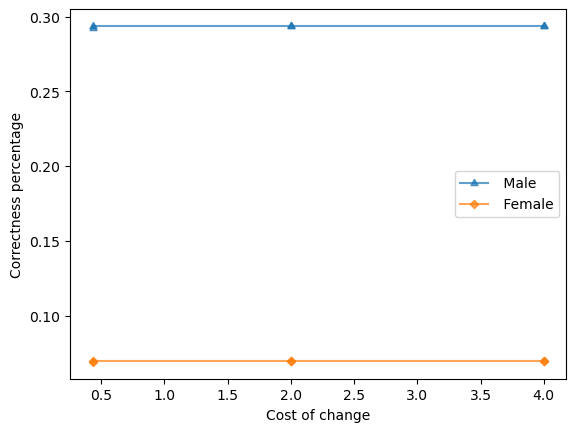

If capital-loss = 0, hours-per-week = FullTime, native-country =  United-States:
	Protected Subgroup ' Male', 45.32% covered out of 6566
		Make capital-loss = 1887 with effectiveness 30.71% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 30.88% and counterfactual cost = 0.44.
		Make hours-per-week = MidTime with effectiveness 30.88% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 30.88% and counterfactual cost = 2.0.
		Make hours-per-week = BrainDrain with effectiveness 30.88% and counterfactual cost = 4.0.
	Protected Subgroup ' Female', 41.31% covered out of 4178
		Make capital-loss = 1887 with effectiveness 7.13% and counterfactual cost = 0.43.
		Make capital-loss = 1902 with effectiveness 7.18% and counterfactual cost = 0.44.
		Make hours-per-week = MidTime with effectiveness 7.18% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 7.18% and counterfactual cost = 2.0.
		Make hours-per-we

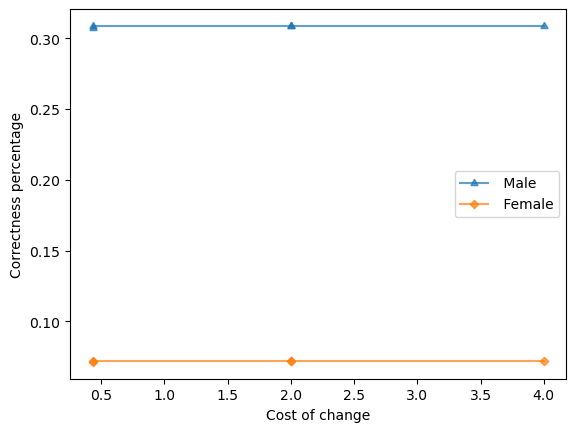

If age = (50.0, 90.0], capital-gain = 0, capital-loss = 0, race =  White:
	Protected Subgroup ' Male', 14.86% covered out of 6566
		Make capital-gain = 7688 with effectiveness 77.05% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 98.46% and counterfactual cost = 0.15.
	Protected Subgroup ' Female', 12.88% covered out of 4178
		Make capital-gain = 7688 with effectiveness 35.13% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 92.75% and counterfactual cost = 0.15.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 7.81.
	Cumulative effectiveness plot for the above recourses:


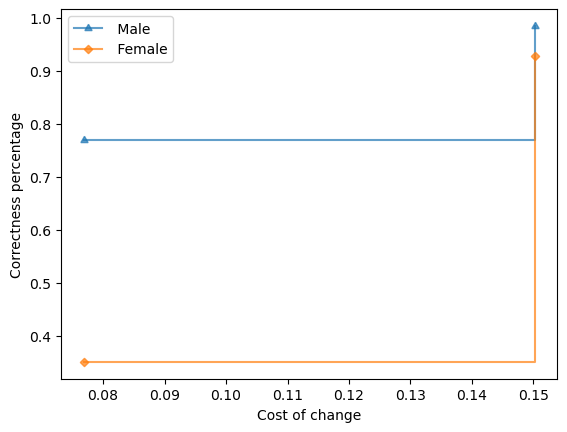

If age = (41.0, 50.0], capital-loss = 0, native-country =  United-States:
	Protected Subgroup ' Male', 13.52% covered out of 6566
		Make capital-loss = 1902 with effectiveness 54.17% and counterfactual cost = 0.44.
		Make age = (50.0, 90.0] with effectiveness 54.17% and counterfactual cost = 10.0.
	Protected Subgroup ' Female', 14.36% covered out of 4178
		Make capital-loss = 1902 with effectiveness 13.50% and counterfactual cost = 0.44.
		Make age = (50.0, 90.0] with effectiveness 13.50% and counterfactual cost = 10.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 7.7.
	Cumulative effectiveness plot for the above recourses:


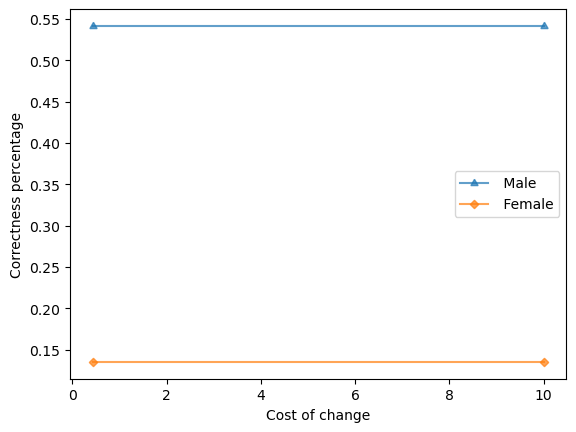

If age = (50.0, 90.0], capital-gain = 0, race =  White:
	Protected Subgroup ' Male', 15.31% covered out of 6566
		Make capital-gain = 7688 with effectiveness 77.71% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 98.51% and counterfactual cost = 0.15.
	Protected Subgroup ' Female', 13.43% covered out of 4178
		Make capital-gain = 7688 with effectiveness 37.25% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 93.05% and counterfactual cost = 0.15.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 7.68.
	Cumulative effectiveness plot for the above recourses:


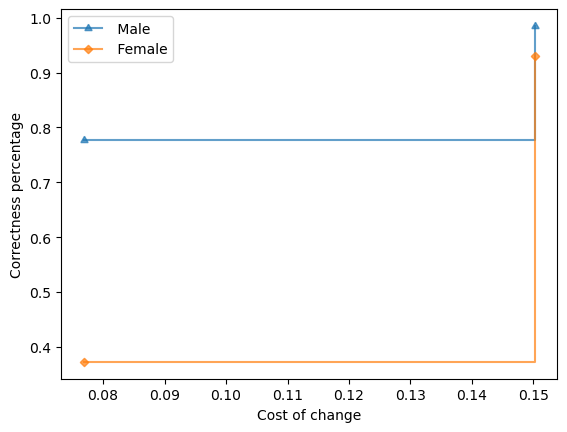

If capital-loss = 0, hours-per-week = FullTime, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 38.68% covered out of 6566
		Make capital-loss = 1887 with effectiveness 32.56% and counterfactual cost = 0.43.
		Make hours-per-week = MidTime with effectiveness 32.56% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 32.56% and counterfactual cost = 2.0.
		Make hours-per-week = BrainDrain with effectiveness 32.56% and counterfactual cost = 4.0.
		Make race =  Black with effectiveness 32.56% and counterfactual cost = 100.0.
		Make hours-per-week = OverTime, race =  Black with effectiveness 32.56% and counterfactual cost = 102.0.
	Protected Subgroup ' Female', 32.05% covered out of 4178
		Make capital-loss = 1887 with effectiveness 8.29% and counterfactual cost = 0.43.
		Make hours-per-week = MidTime with effectiveness 8.29% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 8.29% and counterfactua

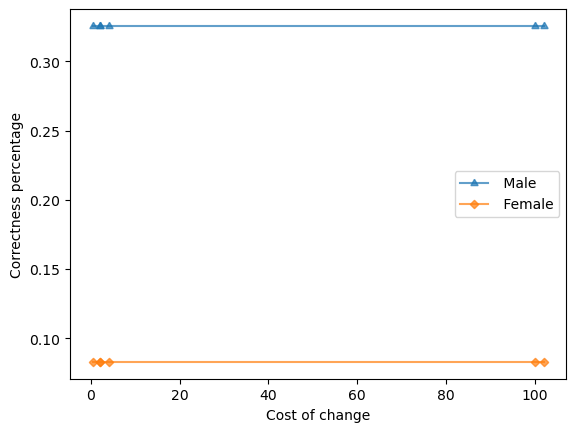

If capital-loss = 0, hours-per-week = FullTime, race =  White:
	Protected Subgroup ' Male', 42.51% covered out of 6566
		Make capital-loss = 1887 with effectiveness 31.06% and counterfactual cost = 0.43.
		Make hours-per-week = MidTime with effectiveness 31.06% and counterfactual cost = 2.0.
		Make hours-per-week = OverTime with effectiveness 31.06% and counterfactual cost = 2.0.
		Make hours-per-week = PartTime with effectiveness 31.06% and counterfactual cost = 4.0.
		Make hours-per-week = BrainDrain with effectiveness 31.06% and counterfactual cost = 4.0.
		Make race =  Asian-Pac-Islander with effectiveness 31.06% and counterfactual cost = 100.0.
		Make race =  Black with effectiveness 31.06% and counterfactual cost = 100.0.
		Make hours-per-week = OverTime, race =  Black with effectiveness 31.06% and counterfactual cost = 102.0.
	Protected Subgroup ' Female', 35.09% covered out of 4178
		Make capital-loss = 1887 with effectiveness 7.98% and counterfactual cost = 0.43.
		Make hours-

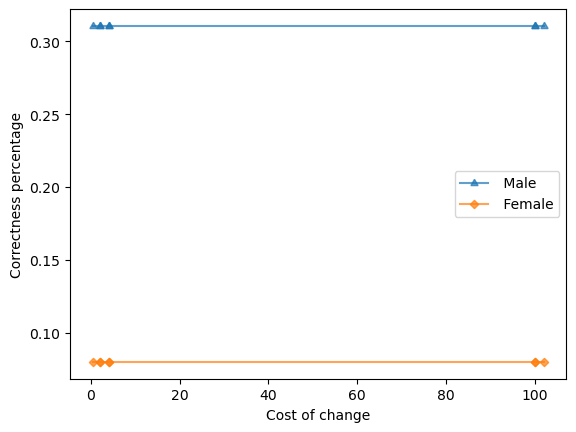

If age = (41.0, 50.0], capital-loss = 0, native-country =  United-States, race =  White:
	Protected Subgroup ' Male', 11.97% covered out of 6566
		Make capital-loss = 1902 with effectiveness 55.34% and counterfactual cost = 0.44.
		Make age = (50.0, 90.0] with effectiveness 55.34% and counterfactual cost = 10.0.
		Make race =  Black with effectiveness 55.34% and counterfactual cost = 100.0.
	Protected Subgroup ' Female', 11.27% covered out of 4178
		Make capital-loss = 1902 with effectiveness 14.65% and counterfactual cost = 0.44.
		Make age = (50.0, 90.0] with effectiveness 14.65% and counterfactual cost = 10.0.
		Make race =  Black with effectiveness 14.65% and counterfactual cost = 100.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 6.98.
	Cumulative effectiveness plot for the above recourses:


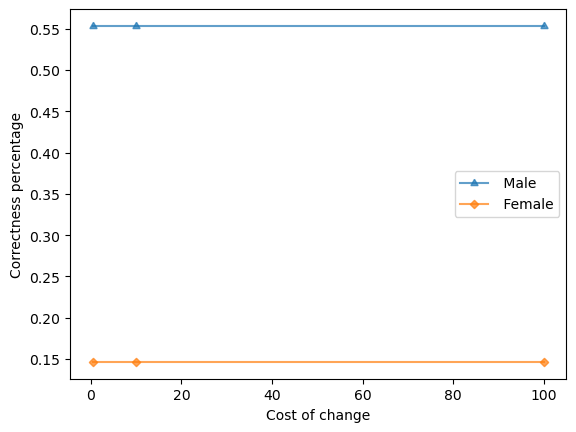

If age = (41.0, 50.0], capital-loss = 0, race =  White:
	Protected Subgroup ' Male', 13.07% covered out of 6566
		Make capital-loss = 1902 with effectiveness 52.91% and counterfactual cost = 0.44.
		Make age = (50.0, 90.0] with effectiveness 52.91% and counterfactual cost = 10.0.
		Make race =  Black with effectiveness 52.91% and counterfactual cost = 100.0.
		Make race =  Asian-Pac-Islander with effectiveness 52.91% and counterfactual cost = 100.0.
	Protected Subgroup ' Female', 12.28% covered out of 4178
		Make capital-loss = 1902 with effectiveness 14.04% and counterfactual cost = 0.44.
		Make age = (50.0, 90.0] with effectiveness 14.04% and counterfactual cost = 10.0.
		Make race =  Black with effectiveness 14.04% and counterfactual cost = 100.0.
		Make race =  Asian-Pac-Islander with effectiveness 14.04% and counterfactual cost = 100.0.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 6.97.
	Cumulative effectiveness plot for the above recourses:


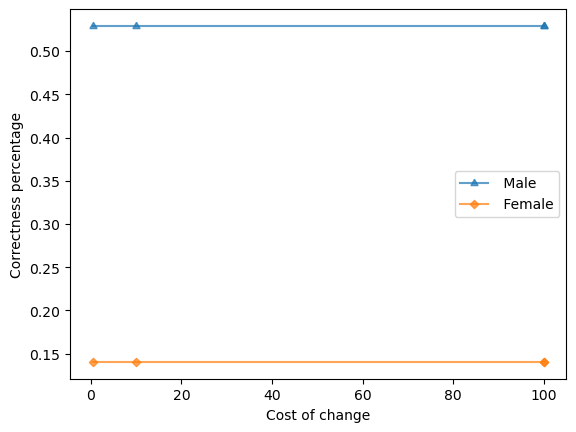

If age = (41.0, 50.0], capital-gain = 0, capital-loss = 0:
	Protected Subgroup ' Male', 14.70% covered out of 6566
		Make capital-gain = 7688 with effectiveness 78.55% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 98.96% and counterfactual cost = 0.15.
		Make capital-loss = 1902 with effectiveness 98.96% and counterfactual cost = 0.44.
		Make age = (50.0, 90.0] with effectiveness 98.96% and counterfactual cost = 10.0.
		Make age = (50.0, 90.0], capital-gain = 7688 with effectiveness 98.96% and counterfactual cost = 10.08.
		Make age = (50.0, 90.0], capital-gain = 15024 with effectiveness 98.96% and counterfactual cost = 10.15.
	Protected Subgroup ' Female', 15.53% covered out of 4178
		Make capital-gain = 7688 with effectiveness 43.61% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 94.76% and counterfactual cost = 0.15.
		Make capital-loss = 1902 with effectiveness 94.76% and counterfactual cost = 0.44.
		Make age = (50.0

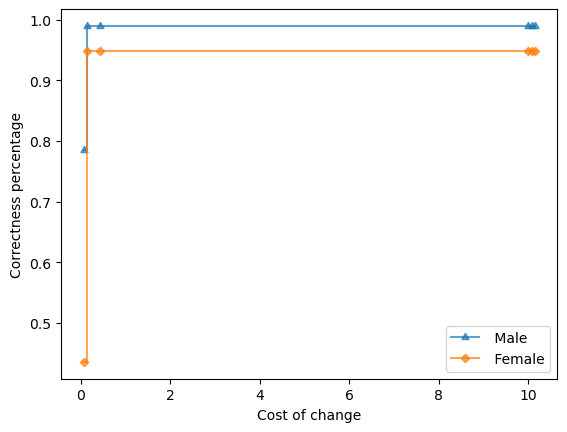

If age = (41.0, 50.0], capital-gain = 0:
	Protected Subgroup ' Male', 15.03% covered out of 6566
		Make capital-gain = 7688 with effectiveness 78.82% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 98.99% and counterfactual cost = 0.15.
		Make age = (50.0, 90.0] with effectiveness 98.99% and counterfactual cost = 10.0.
		Make age = (50.0, 90.0], capital-gain = 7688 with effectiveness 98.99% and counterfactual cost = 10.08.
		Make age = (50.0, 90.0], capital-gain = 15024 with effectiveness 98.99% and counterfactual cost = 10.15.
	Protected Subgroup ' Female', 16.13% covered out of 4178
		Make capital-gain = 7688 with effectiveness 45.10% and counterfactual cost = 0.08.
		Make capital-gain = 15024 with effectiveness 94.96% and counterfactual cost = 0.15.
		Make age = (50.0, 90.0] with effectiveness 94.96% and counterfactual cost = 10.0.
		Make age = (50.0, 90.0], capital-gain = 7688 with effectiveness 94.96% and counterfactual cost = 10.08.
		Make age = (50

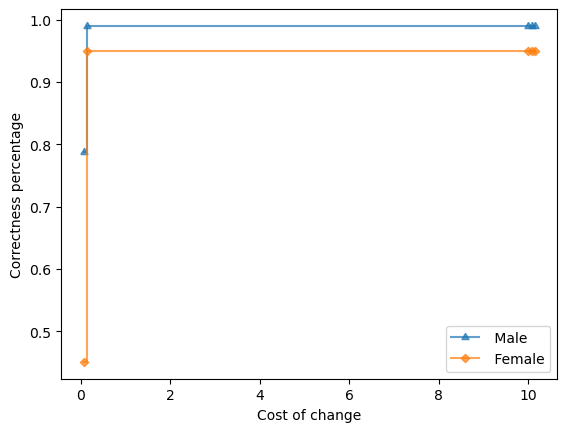

If age = (34.0, 41.0], capital-loss = 0:
	Protected Subgroup ' Male', 16.16% covered out of 6566
		Make age = (50.0, 90.0] with effectiveness 0.28% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 5.37% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], capital-loss = 1902 with effectiveness 47.41% and counterfactual cost = 10.44.
	Protected Subgroup ' Female', 15.70% covered out of 4178
		Make age = (50.0, 90.0] with effectiveness 0.00% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 1.22% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0], capital-loss = 1902 with effectiveness 14.63% and counterfactual cost = 10.44.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 6.6.
	Cumulative effectiveness plot for the above recourses:


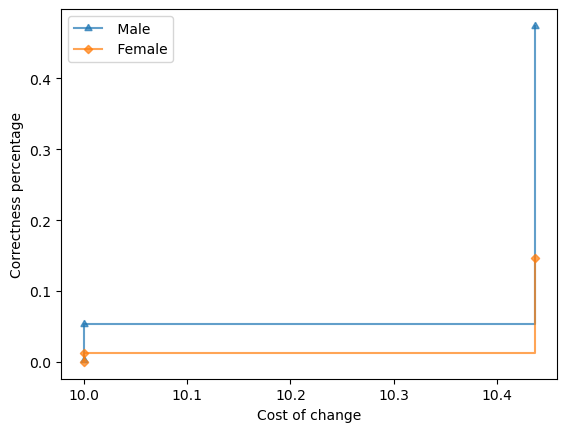

If age = (34.0, 41.0], capital-gain = 0, capital-loss = 0:
	Protected Subgroup ' Male', 15.66% covered out of 6566
		Make capital-gain = 7298 with effectiveness 65.86% and counterfactual cost = 0.07.
		Make capital-gain = 15024 with effectiveness 98.25% and counterfactual cost = 0.15.
		Make age = (50.0, 90.0] with effectiveness 98.25% and counterfactual cost = 10.0.
		Make age = (41.0, 50.0] with effectiveness 98.25% and counterfactual cost = 10.0.
		Make age = (50.0, 90.0], capital-gain = 7688 with effectiveness 98.25% and counterfactual cost = 10.08.
		Make age = (41.0, 50.0], capital-gain = 7688 with effectiveness 98.25% and counterfactual cost = 10.08.
		Make age = (50.0, 90.0], capital-gain = 15024 with effectiveness 98.25% and counterfactual cost = 10.15.
		Make age = (41.0, 50.0], capital-gain = 15024 with effectiveness 99.03% and counterfactual cost = 10.15.
		Make age = (41.0, 50.0], capital-loss = 1902 with effectiveness 99.03% and counterfactual cost = 10.44.
	Protected Sub

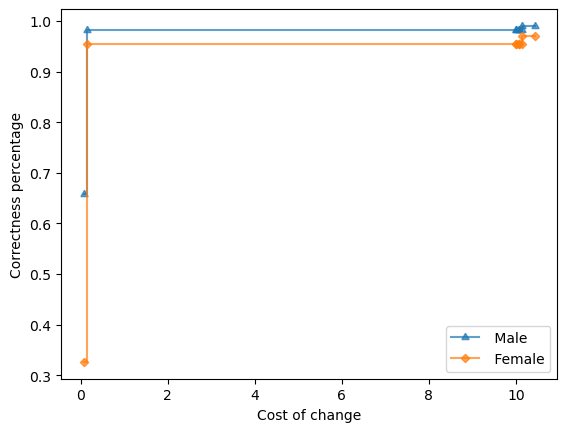

In [24]:
affected_pop_sizes = {sg: ((X_test["sex"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["sex"].unique()}

top_rules,unfairness = facts.select_rules_subset_KStest(
    rules_with_cumulative,
    affected_pop_sizes,
    top_count=50
)

print_recourse_report_KStest_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    unfairness = unfairness,
    show_then_costs=True,
    show_cumulative_plots=True
)